In [33]:
!pip install kaggle
import os
os.makedirs("/root/.kaggle", exist_ok=True)
from google.colab import files
files.upload()  # Upload your kaggle.json file when prompted
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [34]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
!unzip -q cell-images-for-detecting-malaria.zip -d /content/data


Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 96% 650M/675M [00:10<00:00, 76.2MB/s]
100% 675M/675M [00:10<00:00, 69.5MB/s]


In [35]:
# Check the dataset structure
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

data_path = "/content/data"
print("Contents of data directory:")
print(os.listdir(data_path))

# Navigate to the actual image folders
cell_images_path = "/content/data/cell_images"
print("\nContents of cell_images directory:")
print(os.listdir(cell_images_path))

# Check the number of images in each class
parasitized_path = os.path.join(cell_images_path, "Parasitized")
uninfected_path = os.path.join(cell_images_path, "Uninfected")

print(f"\nNumber of parasitized images: {len(os.listdir(parasitized_path))}")
print(f"Number of uninfected images: {len(os.listdir(uninfected_path))}")

Contents of data directory:
['cell_images']

Contents of cell_images directory:
['Parasitized', 'cell_images', 'Uninfected']

Number of parasitized images: 13780
Number of uninfected images: 13780


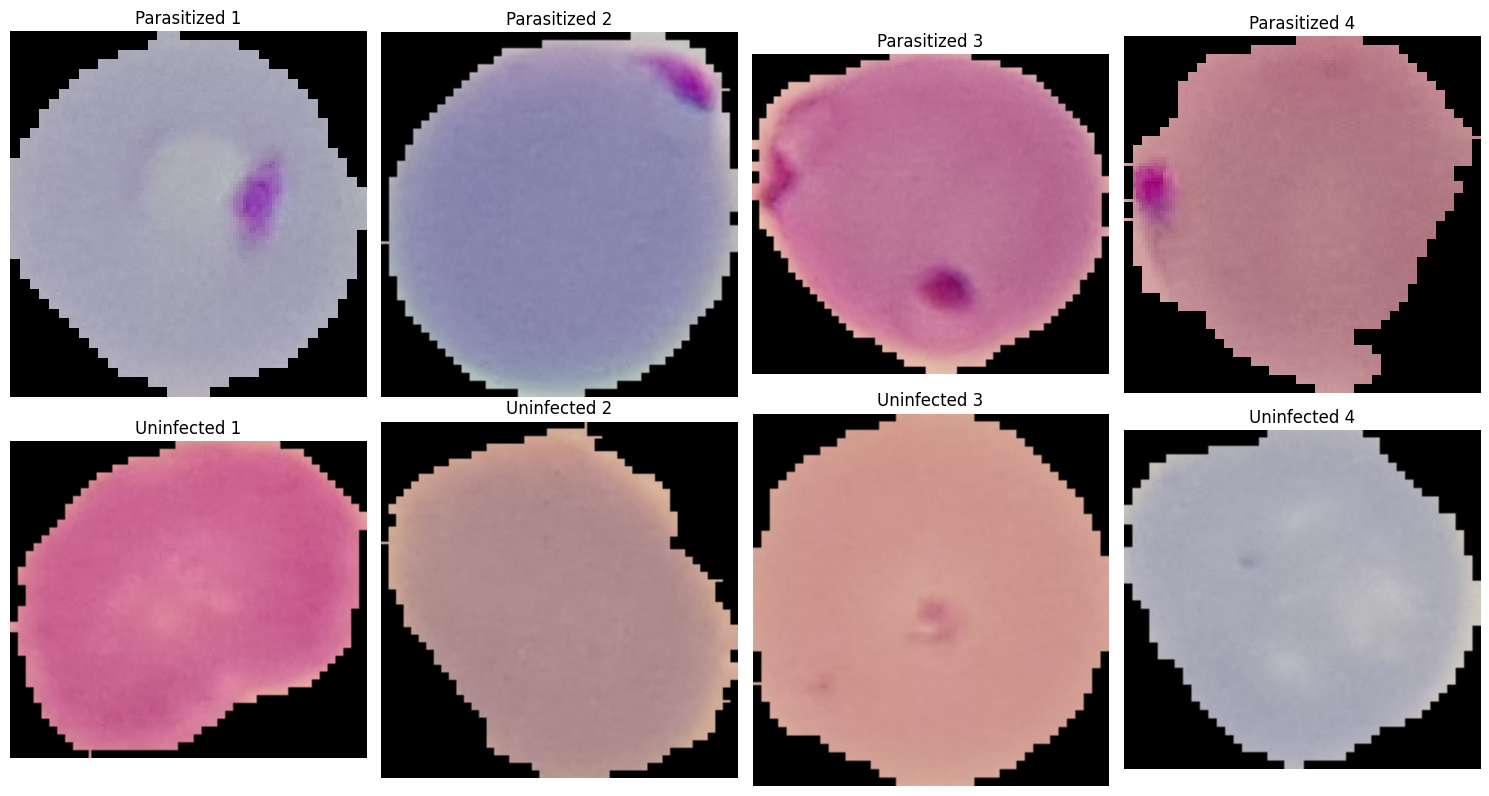

In [36]:
# Display sample images from both classes
def display_sample_images():
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))

    # Parasitized samples
    parasitized_files = os.listdir(parasitized_path)[:4]
    for i, filename in enumerate(parasitized_files):
        img_path = os.path.join(parasitized_path, filename)
        img = mpimg.imread(img_path)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f'Parasitized {i+1}')
        axes[0, i].axis('off')

    # Uninfected samples
    uninfected_files = os.listdir(uninfected_path)[:4]
    for i, filename in enumerate(uninfected_files):
        img_path = os.path.join(uninfected_path, filename)
        img = mpimg.imread(img_path)
        axes[1, i].imshow(img)
        axes[1, i].set_title(f'Uninfected {i+1}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

display_sample_images()

Testing simple preprocessing...


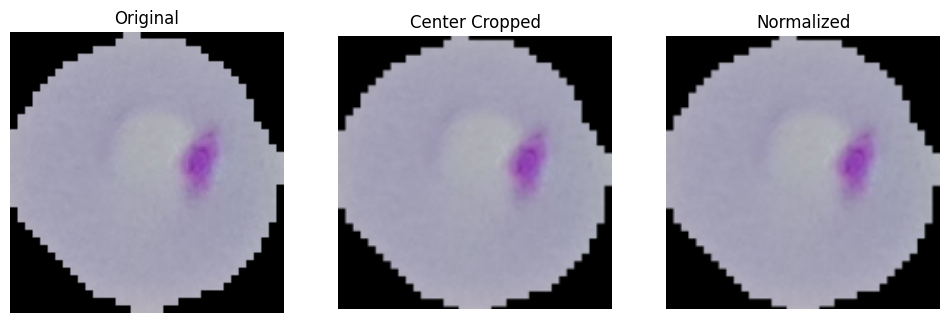

Normalized range: [0.000, 0.769]


In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

# Define the simple preprocessing function first
def simple_preprocess(image_path, target_size=(224, 224)):
    """Simple preprocessing without complex segmentation"""
    # Read image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Simple center crop to focus on cell
    h, w = img.shape[:2]
    crop_size = min(h, w)
    start_x = (w - crop_size) // 2
    start_y = (h - crop_size) // 2
    cropped = img[start_y:start_y + crop_size, start_x:start_x + crop_size]

    # Resize
    resized = cv2.resize(cropped, target_size)

    # Normalize
    normalized = resized.astype(np.float32) / 255.0

    return normalized, resized, img

# Test the function
print("Testing simple preprocessing...")
test_image_path = os.path.join(parasitized_path, os.listdir(parasitized_path)[0])
processed_norm, processed_orig, original_img = simple_preprocess(test_image_path)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(original_img)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(processed_orig)
plt.title('Center Cropped')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(processed_norm)
plt.title('Normalized')
plt.axis('off')
plt.show()

print(f"Normalized range: [{processed_norm.min():.3f}, {processed_norm.max():.3f}]")

In [38]:
def load_dataset_simple(parasitized_dir, uninfected_dir, img_size=(224, 224), max_samples=None):
    """Load dataset with simple preprocessing"""
    images = []
    labels = []

    # Load parasitized images
    print("Loading parasitized images...")
    p_files = [f for f in os.listdir(parasitized_dir) if f.endswith('.png')]
    if max_samples:
        p_files = p_files[:max_samples//2]

    for i, filename in enumerate(p_files):
        if i % 500 == 0:
            print(f"  Processed {i}/{len(p_files)} parasitized images")
        img_path = os.path.join(parasitized_dir, filename)
        processed, _, _ = simple_preprocess(img_path, img_size)
        images.append(processed)
        labels.append(1)  # Parasitized = 1

    # Load uninfected images
    print("Loading uninfected images...")
    u_files = [f for f in os.listdir(uninfected_dir) if f.endswith('.png')]
    if max_samples:
        u_files = u_files[:max_samples//2]

    for i, filename in enumerate(u_files):
        if i % 500 == 0:
            print(f"  Processed {i}/{len(u_files)} uninfected images")
        img_path = os.path.join(uninfected_dir, filename)
        processed, _, _ = simple_preprocess(img_path, img_size)
        images.append(processed)
        labels.append(0)  # Uninfected = 0

    return np.array(images), np.array(labels)

# Load the dataset
print("Loading dataset with simple preprocessing...")
X, y = load_dataset_simple(parasitized_path, uninfected_path, max_samples=2000)

print(f"\nDataset shape: {X.shape}")
print(f"Image range: [{X.min():.3f}, {X.max():.3f}]")
print(f"Class distribution: {np.unique(y, return_counts=True)}")

Loading dataset with simple preprocessing...
Loading parasitized images...
  Processed 0/1000 parasitized images
  Processed 500/1000 parasitized images
Loading uninfected images...
  Processed 0/1000 uninfected images
  Processed 500/1000 uninfected images

Dataset shape: (2000, 224, 224, 3)
Image range: [0.000, 1.000]
Class distribution: (array([0, 1]), array([1000, 1000]))


In [39]:
def quick_quality_check(parasitized_dir, uninfected_dir, sample_size=50):
    """Quick check for corrupted or mislabeled images"""
    print("Performing quick data quality check...")

    issues_found = 0

    # Check parasitized images
    p_files = os.listdir(parasitized_dir)[:sample_size]
    for filename in p_files:
        if filename.endswith('.png'):
            img_path = os.path.join(parasitized_dir, filename)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    print(f"❌ Corrupted image: {filename}")
                    issues_found += 1
            except Exception as e:
                print(f"❌ Error reading {filename}: {e}")
                issues_found += 1

    # Check uninfected images
    u_files = os.listdir(uninfected_dir)[:sample_size]
    for filename in u_files:
        if filename.endswith('.png'):
            img_path = os.path.join(uninfected_dir, filename)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    print(f"❌ Corrupted image: {filename}")
                    issues_found += 1
            except Exception as e:
                print(f"❌ Error reading {filename}: {e}")
                issues_found += 1

    if issues_found == 0:
        print("✅ No corrupted images found in sample check")
    else:
        print(f"⚠️ Found {issues_found} potential issues")

# Run quick quality check
quick_quality_check(parasitized_path, uninfected_path)

Performing quick data quality check...
✅ No corrupted images found in sample check


Testing corrected segmentation with Otsu's method...


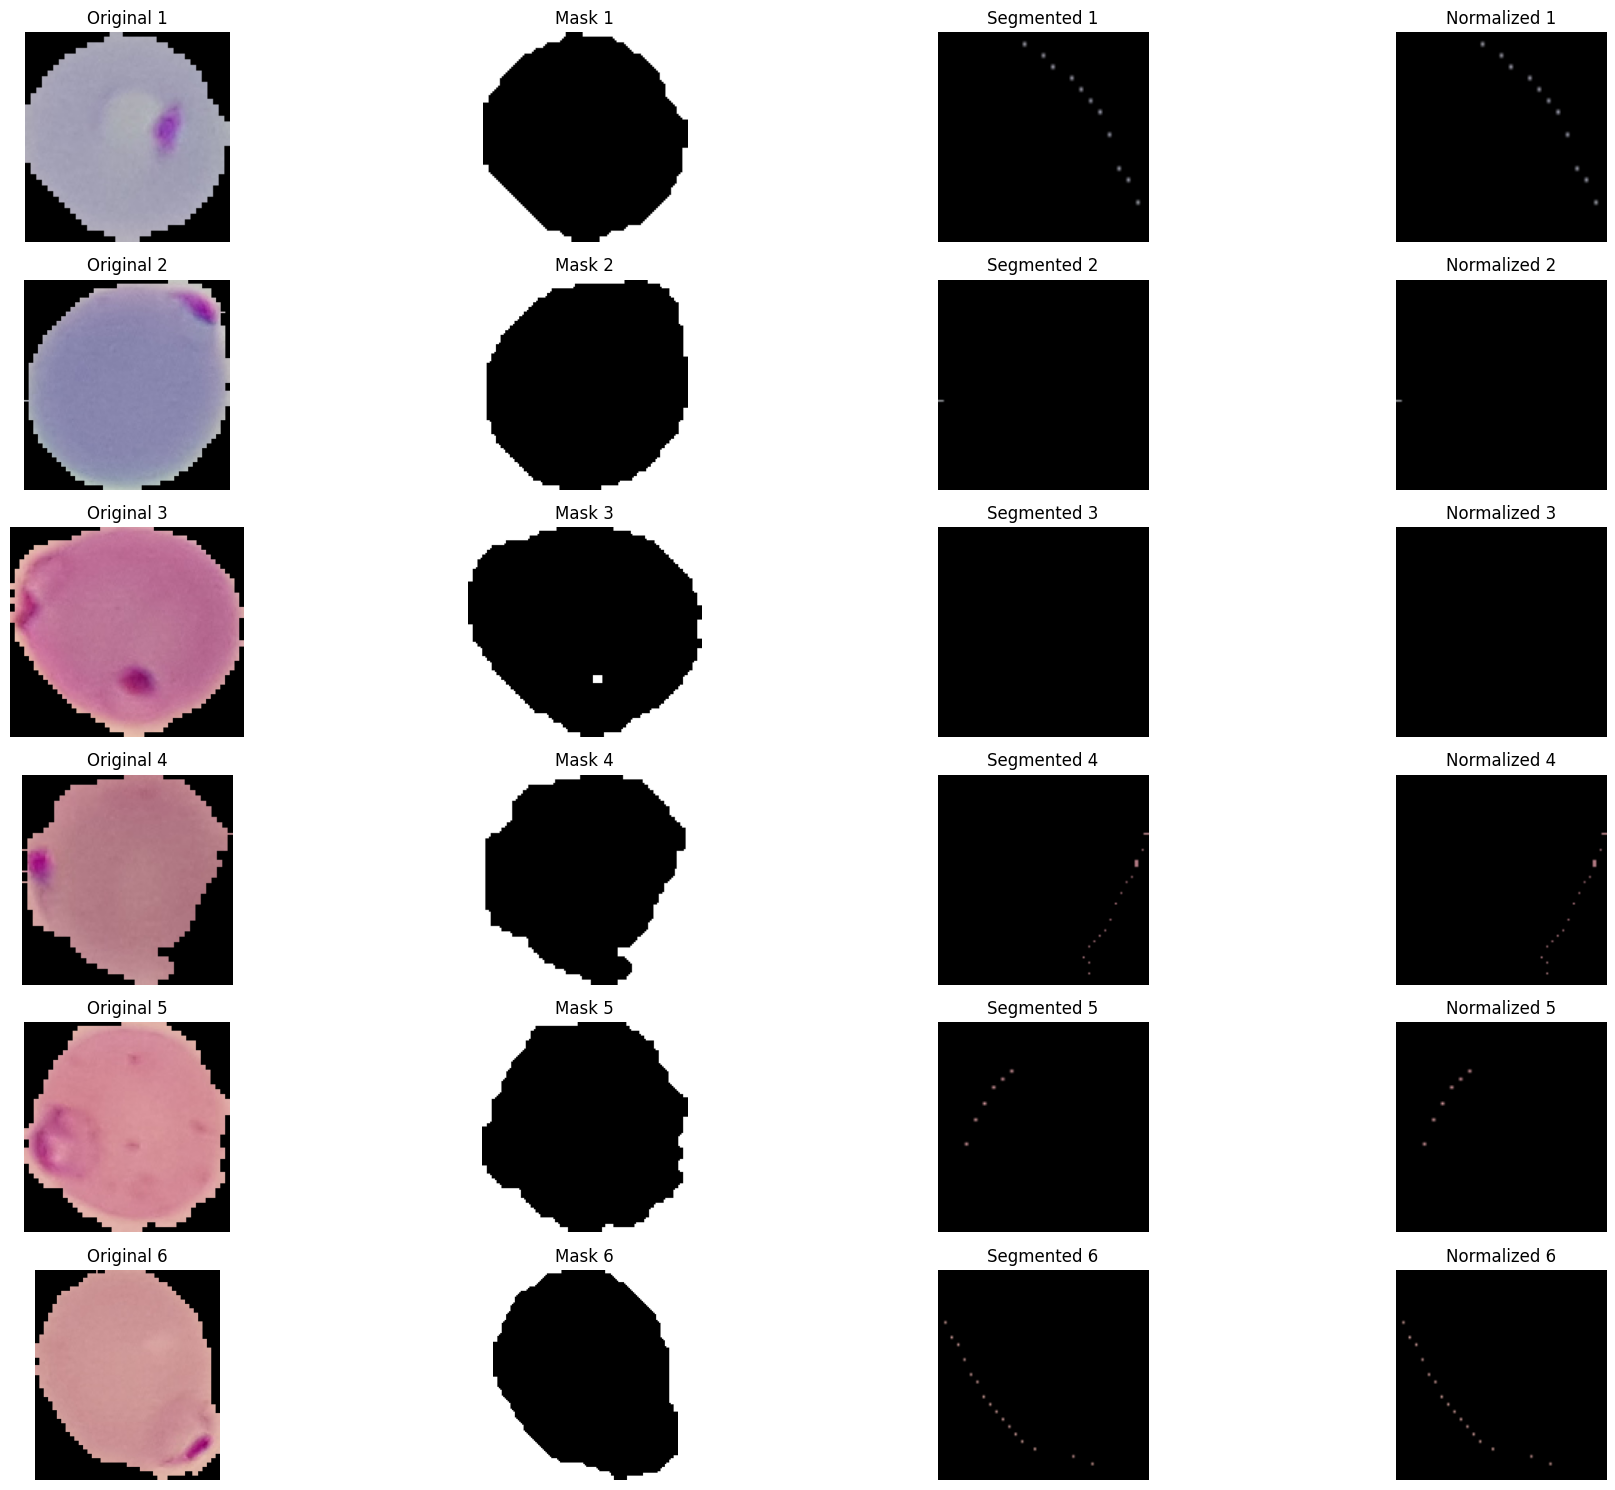

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure, filters

def proper_cell_segmentation(image_path, target_size=(224, 224)):
    """Proper cell segmentation using Otsu's thresholding"""
    # Read image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original_img = img_rgb.copy()

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Otsu's thresholding
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)  # Close small holes
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)   # Remove small noise

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Get the largest contour (assuming it's the cell)
        largest_contour = max(contours, key=cv2.contourArea)

        # Create a mask
        mask = np.zeros_like(gray)
        cv2.drawContours(mask, [largest_contour], -1, 255, -1)

        # Apply mask to original image
        segmented = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

        # Get bounding rectangle with padding
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Add 20% padding
        padding_x = int(w * 0.2)
        padding_y = int(h * 0.2)
        x1 = max(0, x - padding_x)
        y1 = max(0, y - padding_y)
        x2 = min(img_rgb.shape[1], x + w + padding_x)
        y2 = min(img_rgb.shape[0], y + h + padding_y)

        # Extract the cell region
        cell_region = segmented[y1:y2, x1:x2]

        # If the extracted region is empty or too small, use the entire masked image
        if cell_region.size == 0 or min(cell_region.shape[:2]) < 50:
            cell_region = segmented
    else:
        # If no contours found, use center crop as fallback
        print("No contours found, using center crop")
        h, w = img_rgb.shape[:2]
        crop_size = min(h, w) // 2
        center_x, center_y = w // 2, h // 2
        x1 = center_x - crop_size // 2
        y1 = center_y - crop_size // 2
        x2 = center_x + crop_size // 2
        y2 = center_y + crop_size // 2
        cell_region = img_rgb[y1:y2, x1:x2]

    # Resize to target size
    cell_region = cv2.resize(cell_region, target_size)

    # Normalize
    cell_region_normalized = cell_region.astype(np.float32) / 255.0

    return cell_region_normalized, cell_region, original_img, thresh

# Test the corrected segmentation on multiple images
print("Testing corrected segmentation with Otsu's method...")
test_files = os.listdir(parasitized_path)[:6]  # Test more images

plt.figure(figsize=(20, 15))
for i, filename in enumerate(test_files):
    if i >= 6:  # Limit to 6 images for display
        break

    img_path = os.path.join(parasitized_path, filename)

    try:
        segmented_norm, segmented_orig, original_img, mask = proper_cell_segmentation(img_path)

        # Plot original
        plt.subplot(6, 4, i*4 + 1)
        plt.imshow(original_img)
        plt.title(f'Original {i+1}')
        plt.axis('off')

        # Plot mask
        plt.subplot(6, 4, i*4 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Mask {i+1}')
        plt.axis('off')

        # Plot segmented (original scale)
        plt.subplot(6, 4, i*4 + 3)
        plt.imshow(segmented_orig)
        plt.title(f'Segmented {i+1}')
        plt.axis('off')

        # Plot segmented (normalized)
        plt.subplot(6, 4, i*4 + 4)
        plt.imshow(segmented_norm)
        plt.title(f'Normalized {i+1}')
        plt.axis('off')

    except Exception as e:
        print(f"Error processing {filename}: {e}")

plt.tight_layout()
plt.show()

Testing enhanced segmentation...


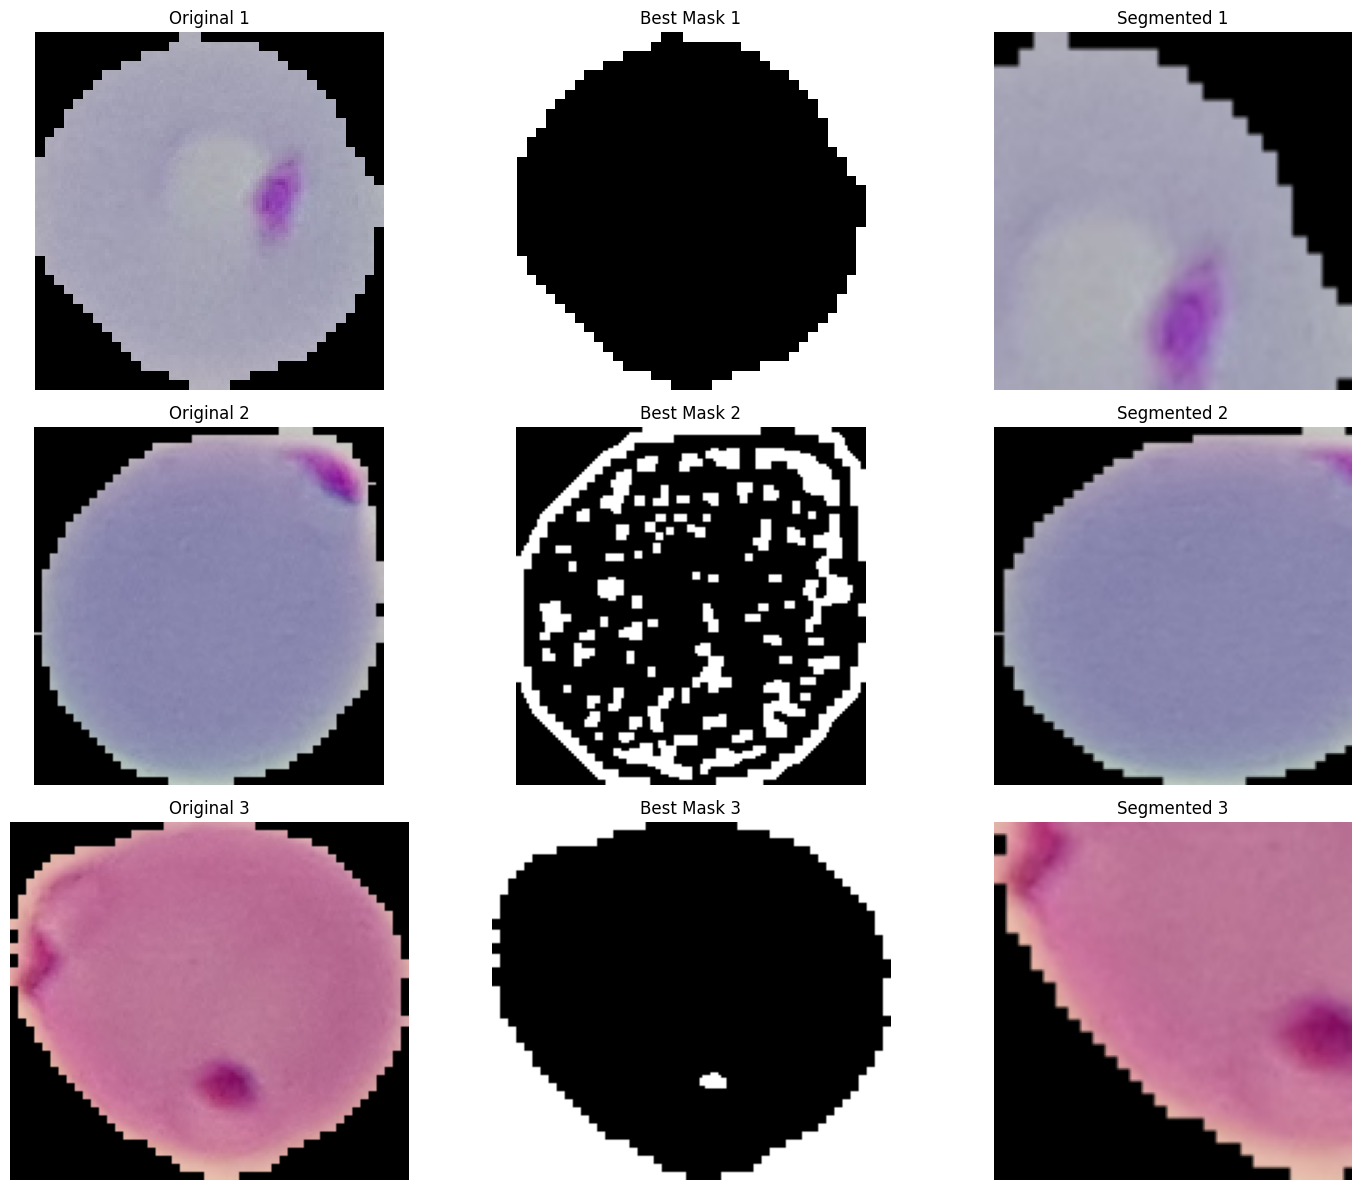

In [41]:
def enhanced_segmentation(image_path, target_size=(224, 224)):
    """Enhanced segmentation trying multiple methods"""
    # Read image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Method 1: Otsu on grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Method 2: Otsu on value channel (HSV)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    value_channel = hsv[:, :, 2]
    _, thresh2 = cv2.threshold(value_channel, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Method 3: Adaptive thresholding
    thresh3 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    # Choose the best mask (most white pixels but not too many)
    masks = [thresh1, thresh2, thresh3]
    mask_scores = []

    for mask in masks:
        white_ratio = np.sum(mask == 255) / mask.size
        # Ideal mask has reasonable amount of white (not too much, not too little)
        score = -abs(white_ratio - 0.3)  # Prefer around 30% white
        mask_scores.append(score)

    best_mask = masks[np.argmax(mask_scores)]

    # Clean the mask
    kernel = np.ones((3, 3), np.uint8)
    best_mask = cv2.morphologyEx(best_mask, cv2.MORPH_CLOSE, kernel)
    best_mask = cv2.morphologyEx(best_mask, cv2.MORPH_OPEN, kernel)

    # Find contours and proceed as before
    contours, _ = cv2.findContours(best_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Add padding
        padding = 15
        x1, y1 = max(0, x-padding), max(0, y-padding)
        x2, y2 = min(img_rgb.shape[1], x+w+padding), min(img_rgb.shape[0], y+h+padding)

        segmented = img_rgb[y1:y2, x1:x2]
    else:
        # Fallback: center crop
        h, w = img_rgb.shape[:2]
        crop_size = min(h, w)
        start_x, start_y = (w - crop_size) // 2, (h - crop_size) // 2
        segmented = img_rgb[start_y:start_y+crop_size, start_x:start_x+crop_size]

    # Resize and normalize
    segmented = cv2.resize(segmented, target_size)
    segmented_norm = segmented.astype(np.float32) / 255.0

    return segmented_norm, segmented, img_rgb, best_mask

# Test enhanced segmentation
print("Testing enhanced segmentation...")
test_files = os.listdir(parasitized_path)[:3]

plt.figure(figsize=(15, 12))
for i, filename in enumerate(test_files):
    img_path = os.path.join(parasitized_path, filename)

    try:
        seg_norm, seg_orig, original, mask = enhanced_segmentation(img_path)

        # Original
        plt.subplot(3, 3, i*3 + 1)
        plt.imshow(original)
        plt.title(f'Original {i+1}')
        plt.axis('off')

        # Mask
        plt.subplot(3, 3, i*3 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Best Mask {i+1}')
        plt.axis('off')

        # Segmented
        plt.subplot(3, 3, i*3 + 3)
        plt.imshow(seg_orig)
        plt.title(f'Segmented {i+1}')
        plt.axis('off')

    except Exception as e:
        print(f"Error with {filename}: {e}")

plt.tight_layout()
plt.show()

In [42]:
def validate_dataset(X, y):
    """Validate the dataset for training readiness"""
    print("Validating dataset...")

    # Check for NaN values
    if np.isnan(X).any():
        print("❌ Found NaN values in images")
        return False

    # Check for infinite values
    if np.isinf(X).any():
        print("❌ Found infinite values in images")
        return False

    # Check data range
    if X.min() < 0 or X.max() > 1:
        print("❌ Data not properly normalized")
        return False

    # Check shapes
    if X.shape[1:] != (224, 224, 3):
        print("❌ Incorrect image dimensions")
        return False

    # Check class balance
    unique, counts = np.unique(y, return_counts=True)
    balance_ratio = counts[0] / counts[1] if len(counts) > 1 else 1
    if balance_ratio < 0.8 or balance_ratio > 1.2:
        print(f"⚠️ Class imbalance detected: {dict(zip(unique, counts))}")

    print("✅ Dataset validation passed!")
    print(f"   - Shape: {X.shape}")
    print(f"   - Range: [{X.min():.3f}, {X.max():.3f}]")
    print(f"   - Classes: {dict(zip(unique, counts))}")
    return True

# Validate current dataset
validate_dataset(X, y)

Validating dataset...
✅ Dataset validation passed!
   - Shape: (2000, 224, 224, 3)
   - Range: [0.000, 1.000]
   - Classes: {np.int64(0): np.int64(1000), np.int64(1): np.int64(1000)}


True

In [43]:
# Install only what we need
!pip install -q torch torchvision torchaudio
!pip install -q matplotlib opencv-python scikit-image pillow
!pip install -q requests tqdm ninja
!pip install -q tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 4.8 MB/s eta 0:00:00


In [44]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import zipfile

# First, let's check where your data actually is
print("Checking data directory structure...")
data_path = "/content/data"
print(f"Contents of {data_path}: {os.listdir(data_path)}")

# Navigate to the actual image directories
cell_images_path = "/content/data/cell_images"
print(f"Contents of cell_images: {os.listdir(cell_images_path)}")

parasitized_path = os.path.join(cell_images_path, "Parasitized")
uninfected_path = os.path.join(cell_images_path, "Uninfected")

print(f"Parasitized path exists: {os.path.exists(parasitized_path)}")
print(f"Uninfected path exists: {os.path.exists(uninfected_path)}")
print(f"Parasitized images: {len(os.listdir(parasitized_path))}")
print(f"Uninfected images: {len(os.listdir(uninfected_path))}")

# Create directories for augmented dataset
def prepare_augmentation_dataset(parasitized_path, uninfected_path, output_dir, img_size=256, num_samples=1000):
    """Prepare dataset for advanced augmentation"""

    # Create output directories
    aug_parasitized_dir = os.path.join(output_dir, 'parasitized')
    aug_uninfected_dir = os.path.join(output_dir, 'uninfected')
    os.makedirs(aug_parasitized_dir, exist_ok=True)
    os.makedirs(aug_uninfected_dir, exist_ok=True)

    def process_images(source_dir, target_dir, class_name, max_samples):
        print(f"Processing {class_name} images...")
        files = [f for f in os.listdir(source_dir) if f.endswith('.png')][:max_samples]

        for i, filename in enumerate(files):
            if i % 100 == 0:
                print(f"  Processed {i}/{len(files)} {class_name} images")

            # Read and resize image
            img_path = os.path.join(source_dir, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img, (img_size, img_size))

            # Save processed image
            output_path = os.path.join(target_dir, f"original_{class_name}_{i:05d}.png")
            cv2.imwrite(output_path, cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR))

        print(f"✅ Completed {class_name}: {len(os.listdir(target_dir))} images")

    # Process both classes
    process_images(parasitized_path, aug_parasitized_dir, 'parasitized', num_samples)
    process_images(uninfected_path, aug_uninfected_dir, 'uninfected', num_samples)

    return aug_parasitized_dir, aug_uninfected_dir

# Prepare the dataset with correct paths
print("Preparing dataset for advanced augmentation...")
aug_data_dir = '/content/augmentation_dataset'
parasitized_aug_dir, uninfected_aug_dir = prepare_augmentation_dataset(
    parasitized_path, uninfected_path, aug_data_dir, num_samples=1000
)

print(f"Augmentation dataset prepared at: {aug_data_dir}")
print(f"Parasitized images: {len(os.listdir(parasitized_aug_dir))}")
print(f"Uninfected images: {len(os.listdir(uninfected_aug_dir))}")

Checking data directory structure...
Contents of /content/data: ['cell_images']
Contents of cell_images: ['Parasitized', 'cell_images', 'Uninfected']
Parasitized path exists: True
Uninfected path exists: True
Parasitized images: 13780
Uninfected images: 13780
Preparing dataset for advanced augmentation...
Processing parasitized images...
  Processed 0/1000 parasitized images
  Processed 100/1000 parasitized images
  Processed 200/1000 parasitized images
  Processed 300/1000 parasitized images
  Processed 400/1000 parasitized images
  Processed 500/1000 parasitized images
  Processed 600/1000 parasitized images
  Processed 700/1000 parasitized images
  Processed 800/1000 parasitized images
  Processed 900/1000 parasitized images
✅ Completed parasitized: 1000 images
Processing uninfected images...
  Processed 0/1000 uninfected images
  Processed 100/1000 uninfected images
  Processed 200/1000 uninfected images
  Processed 300/1000 uninfected images
  Processed 400/1000 uninfected images


Testing advanced GAN-like augmentation...


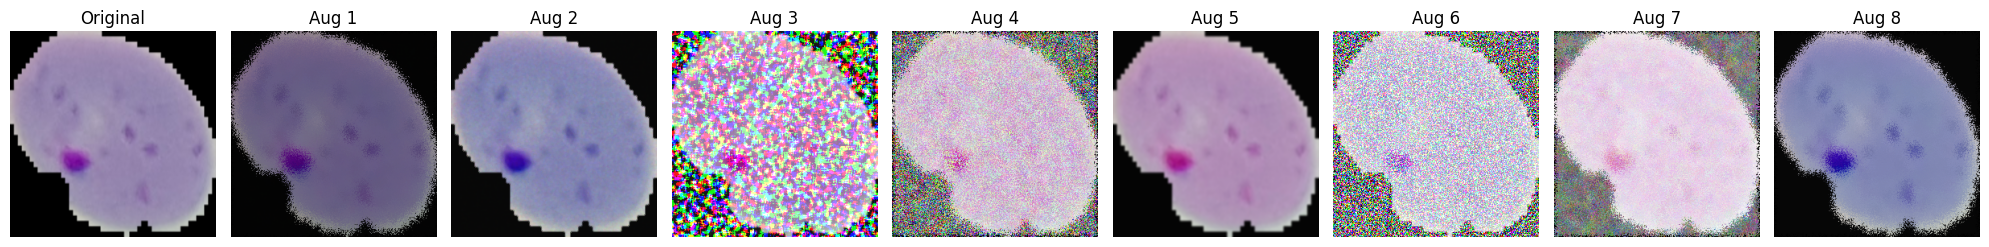

In [45]:
def advanced_gan_like_augmentation(img):
    """Advanced augmentation that simulates GAN diversity"""
    augmented = img.copy()

    # 1. Color space transformations (HSV)
    hsv = cv2.cvtColor(augmented, cv2.COLOR_RGB2HSV).astype(np.float32)

    # Random hue shift (-20 to +20 degrees)
    hue_shift = np.random.uniform(-20, 20)
    hsv[:, :, 0] = (hsv[:, :, 0] + hue_shift) % 180

    # Random saturation adjustment (0.7x to 1.3x)
    sat_scale = np.random.uniform(0.7, 1.3)
    hsv[:, :, 1] = np.clip(hsv[:, :, 1] * sat_scale, 0, 255)

    # Random value adjustment (0.8x to 1.2x)
    val_scale = np.random.uniform(0.8, 1.2)
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * val_scale, 0, 255)

    augmented = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)

    # 2. Contrast and brightness
    alpha = np.random.uniform(0.8, 1.2)  # Contrast control
    beta = np.random.uniform(-10, 10)    # Brightness control
    augmented = cv2.convertScaleAbs(augmented, alpha=alpha, beta=beta)

    # 3. Advanced noise injection
    noise_type = np.random.choice(['gaussian', 'speckle', 'none'])
    if noise_type == 'gaussian':
        noise = np.random.normal(0, 12, augmented.shape).astype(np.uint8)
        augmented = cv2.add(augmented, noise)
    elif noise_type == 'speckle':
        noise = np.random.normal(0, 0.05, augmented.shape)
        augmented = augmented + augmented * noise
        augmented = np.clip(augmented, 0, 255).astype(np.uint8)

    # 4. Advanced blur effects
    blur_type = np.random.choice(['gaussian', 'median', 'bilateral', 'none'])
    if blur_type == 'gaussian':
        ksize = np.random.choice([3, 5])
        augmented = cv2.GaussianBlur(augmented, (ksize, ksize), 0)
    elif blur_type == 'median':
        ksize = np.random.choice([3, 5])
        augmented = cv2.medianBlur(augmented, ksize)
    elif blur_type == 'bilateral':
        augmented = cv2.bilateralFilter(augmented, 9, 75, 75)

    # 5. Elastic transformations (simulated)
    if np.random.random() > 0.7:
        # Simple elastic distortion simulation
        rows, cols = augmented.shape[:2]
        dx = np.random.uniform(-5, 5, (rows, cols))
        dy = np.random.uniform(-5, 5, (rows, cols))

        x, y = np.meshgrid(np.arange(cols), np.arange(rows))
        map_x = np.float32(x + dx)
        map_y = np.float32(y + dy)

        augmented = cv2.remap(augmented, map_x, map_y, cv2.INTER_LINEAR)

    # 6. Random erasing (cutout)
    if np.random.random() > 0.8:
        h, w = augmented.shape[:2]
        erasure_h = np.random.randint(h//10, h//4)
        erasure_w = np.random.randint(w//10, w//4)
        erasure_x = np.random.randint(0, w - erasure_w)
        erasure_y = np.random.randint(0, h - erasure_h)

        augmented[erasure_y:erasure_y+erasure_h, erasure_x:erasure_x+erasure_w] = 0

    return augmented

# Test the advanced augmentation
print("Testing advanced GAN-like augmentation...")
test_img_path = os.path.join(parasitized_aug_dir, os.listdir(parasitized_aug_dir)[0])
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Generate multiple augmented versions
augmented_images = []
for i in range(8):
    aug_img = advanced_gan_like_augmentation(test_img)
    augmented_images.append(aug_img)

# Display results
plt.figure(figsize=(20, 5))
plt.subplot(1, 9, 1)
plt.imshow(test_img)
plt.title('Original')
plt.axis('off')

for i, aug_img in enumerate(augmented_images):
    plt.subplot(1, 9, i+2)
    plt.imshow(aug_img)
    plt.title(f'Aug {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Testing advanced GAN-like augmentation...


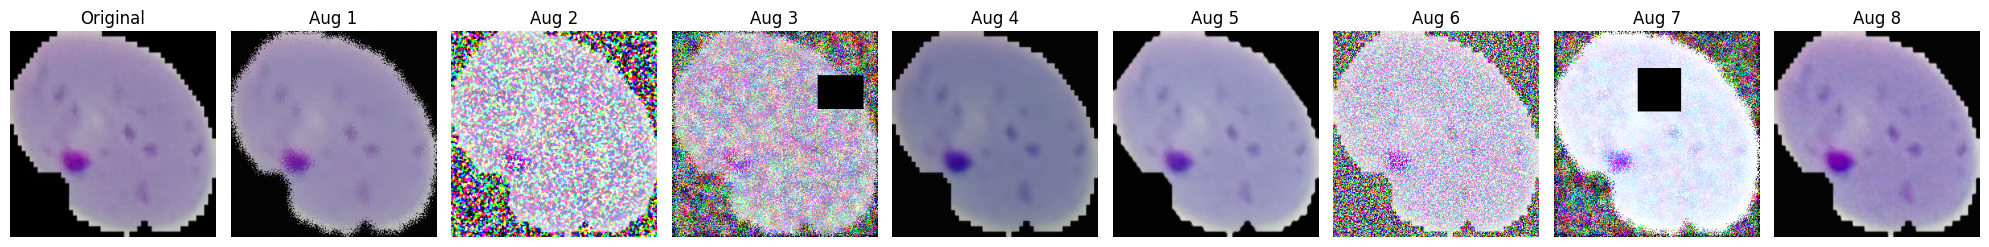

In [46]:
def advanced_gan_like_augmentation(img):
    """Advanced augmentation that simulates GAN diversity"""
    augmented = img.copy()

    # 1. Color space transformations (HSV)
    hsv = cv2.cvtColor(augmented, cv2.COLOR_RGB2HSV).astype(np.float32)

    # Random hue shift (-20 to +20 degrees)
    hue_shift = np.random.uniform(-20, 20)
    hsv[:, :, 0] = (hsv[:, :, 0] + hue_shift) % 180

    # Random saturation adjustment (0.7x to 1.3x)
    sat_scale = np.random.uniform(0.7, 1.3)
    hsv[:, :, 1] = np.clip(hsv[:, :, 1] * sat_scale, 0, 255)

    # Random value adjustment (0.8x to 1.2x)
    val_scale = np.random.uniform(0.8, 1.2)
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * val_scale, 0, 255)

    augmented = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)

    # 2. Contrast and brightness
    alpha = np.random.uniform(0.8, 1.2)  # Contrast control
    beta = np.random.uniform(-10, 10)    # Brightness control
    augmented = cv2.convertScaleAbs(augmented, alpha=alpha, beta=beta)

    # 3. Advanced noise injection
    noise_type = np.random.choice(['gaussian', 'speckle', 'none'])
    if noise_type == 'gaussian':
        noise = np.random.normal(0, 12, augmented.shape).astype(np.uint8)
        augmented = cv2.add(augmented, noise)
    elif noise_type == 'speckle':
        noise = np.random.normal(0, 0.05, augmented.shape)
        augmented = augmented + augmented * noise
        augmented = np.clip(augmented, 0, 255).astype(np.uint8)

    # 4. Advanced blur effects
    blur_type = np.random.choice(['gaussian', 'median', 'bilateral', 'none'])
    if blur_type == 'gaussian':
        ksize = np.random.choice([3, 5])
        augmented = cv2.GaussianBlur(augmented, (ksize, ksize), 0)
    elif blur_type == 'median':
        ksize = np.random.choice([3, 5])
        augmented = cv2.medianBlur(augmented, ksize)
    elif blur_type == 'bilateral':
        augmented = cv2.bilateralFilter(augmented, 9, 75, 75)

    # 5. Elastic transformations (simulated)
    if np.random.random() > 0.7:
        # Simple elastic distortion simulation
        rows, cols = augmented.shape[:2]
        dx = np.random.uniform(-5, 5, (rows, cols))
        dy = np.random.uniform(-5, 5, (rows, cols))

        x, y = np.meshgrid(np.arange(cols), np.arange(rows))
        map_x = np.float32(x + dx)
        map_y = np.float32(y + dy)

        augmented = cv2.remap(augmented, map_x, map_y, cv2.INTER_LINEAR)

    # 6. Random erasing (cutout)
    if np.random.random() > 0.8:
        h, w = augmented.shape[:2]
        erasure_h = np.random.randint(h//10, h//4)
        erasure_w = np.random.randint(w//10, w//4)
        erasure_x = np.random.randint(0, w - erasure_w)
        erasure_y = np.random.randint(0, h - erasure_h)

        augmented[erasure_y:erasure_y+erasure_h, erasure_x:erasure_x+erasure_w] = 0

    return augmented

# Test the advanced augmentation
print("Testing advanced GAN-like augmentation...")
test_img_path = os.path.join(parasitized_aug_dir, os.listdir(parasitized_aug_dir)[0])
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Generate multiple augmented versions
augmented_images = []
for i in range(8):
    aug_img = advanced_gan_like_augmentation(test_img)
    augmented_images.append(aug_img)

# Display results
plt.figure(figsize=(20, 5))
plt.subplot(1, 9, 1)
plt.imshow(test_img)
plt.title('Original')
plt.axis('off')

for i, aug_img in enumerate(augmented_images):
    plt.subplot(1, 9, i+2)
    plt.imshow(aug_img)
    plt.title(f'Aug {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [47]:
def generate_synthetic_dataset(real_dir, output_dir, num_synthetic=500, target_size=(224, 224)):
    """Generate synthetic dataset using advanced augmentation"""
    os.makedirs(output_dir, exist_ok=True)

    real_images = [f for f in os.listdir(real_dir) if f.endswith('.png')]
    synthetic_count = 0

    print(f"Generating {num_synthetic} synthetic images from {len(real_images)} real images...")

    while synthetic_count < num_synthetic:
        # Select random real image
        real_img_name = np.random.choice(real_images)
        real_img_path = os.path.join(real_dir, real_img_name)

        # Read image
        img = cv2.imread(real_img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Apply advanced augmentation
        synthetic_img = advanced_gan_like_augmentation(img)

        # Resize to target size
        synthetic_img = cv2.resize(synthetic_img, target_size)

        # Save synthetic image
        output_path = os.path.join(output_dir, f'synthetic_{synthetic_count:05d}.png')
        cv2.imwrite(output_path, cv2.cvtColor(synthetic_img, cv2.COLOR_RGB2BGR))

        synthetic_count += 1

        if synthetic_count % 100 == 0:
            print(f"  Generated {synthetic_count}/{num_synthetic} synthetic images")

    print(f"✅ Generated {synthetic_count} synthetic images in {output_dir}")
    return output_dir

# Generate synthetic datasets for both classes
print("Generating synthetic parasitized images...")
synthetic_parasitized_dir = generate_synthetic_dataset(parasitized_aug_dir, '/content/synthetic_parasitized', 500)

print("Generating synthetic uninfected images...")
synthetic_uninfected_dir = generate_synthetic_dataset(uninfected_aug_dir, '/content/synthetic_uninfected', 500)

print(f"Synthetic parasitized: {len(os.listdir(synthetic_parasitized_dir))} images")
print(f"Synthetic uninfected: {len(os.listdir(synthetic_uninfected_dir))} images")

Generating synthetic parasitized images...
Generating 500 synthetic images from 1000 real images...
  Generated 100/500 synthetic images
  Generated 200/500 synthetic images
  Generated 300/500 synthetic images
  Generated 400/500 synthetic images
  Generated 500/500 synthetic images
✅ Generated 500 synthetic images in /content/synthetic_parasitized
Generating synthetic uninfected images...
Generating 500 synthetic images from 1000 real images...
  Generated 100/500 synthetic images
  Generated 200/500 synthetic images
  Generated 300/500 synthetic images
  Generated 400/500 synthetic images
  Generated 500/500 synthetic images
✅ Generated 500 synthetic images in /content/synthetic_uninfected
Synthetic parasitized: 500 images
Synthetic uninfected: 500 images


In [48]:
def create_final_augmented_dataset(original_parasitized, original_uninfected,
                                 synthetic_parasitized, synthetic_uninfected,
                                 output_dir, target_size=(224, 224)):
    """Create final augmented dataset combining original and synthetic images"""

    final_parasitized_dir = os.path.join(output_dir, 'Parasitized')
    final_uninfected_dir = os.path.join(output_dir, 'Uninfected')
    os.makedirs(final_parasitized_dir, exist_ok=True)
    os.makedirs(final_uninfected_dir, exist_ok=True)

    def copy_images(source_dir, target_dir, prefix):
        count = 0
        for filename in os.listdir(source_dir):
            if filename.endswith('.png'):
                img_path = os.path.join(source_dir, filename)
                img = cv2.imread(img_path)
                if img is None:
                    continue

                # Resize if needed
                if img.shape[:2] != target_size:
                    img = cv2.resize(img, target_size)

                # Save with new name
                output_path = os.path.join(target_dir, f"{prefix}_{count:05d}.png")
                cv2.imwrite(output_path, img)
                count += 1
        return count

    print("Creating final augmented dataset...")

    # Copy original images
    orig_para_count = copy_images(original_parasitized, final_parasitized_dir, 'original')
    orig_uninf_count = copy_images(original_uninfected, final_uninfected_dir, 'original')

    # Copy synthetic images
    synth_para_count = copy_images(synthetic_parasitized, final_parasitized_dir, 'synthetic')
    synth_uninf_count = copy_images(synthetic_uninfected, final_uninfected_dir, 'synthetic')

    print("✅ Final augmented dataset created!")
    print(f"Parasitized: {orig_para_count} original + {synth_para_count} synthetic = {orig_para_count + synth_para_count} total")
    print(f"Uninfected: {orig_uninf_count} original + {synth_uninf_count} synthetic = {orig_uninf_count + synth_uninf_count} total")

    return output_dir

# Create the final dataset
final_dataset_dir = create_final_augmented_dataset(
    parasitized_path, uninfected_path,
    synthetic_parasitized_dir, synthetic_uninfected_dir,
    '/content/final_augmented_dataset'
)

Creating final augmented dataset...
✅ Final augmented dataset created!
Parasitized: 13779 original + 500 synthetic = 14279 total
Uninfected: 13779 original + 500 synthetic = 14279 total


=== Augmented Dataset Summary ===
Parasitized images: 14279
Uninfected images: 14279
Total images: 28558
Balance ratio: 1.00


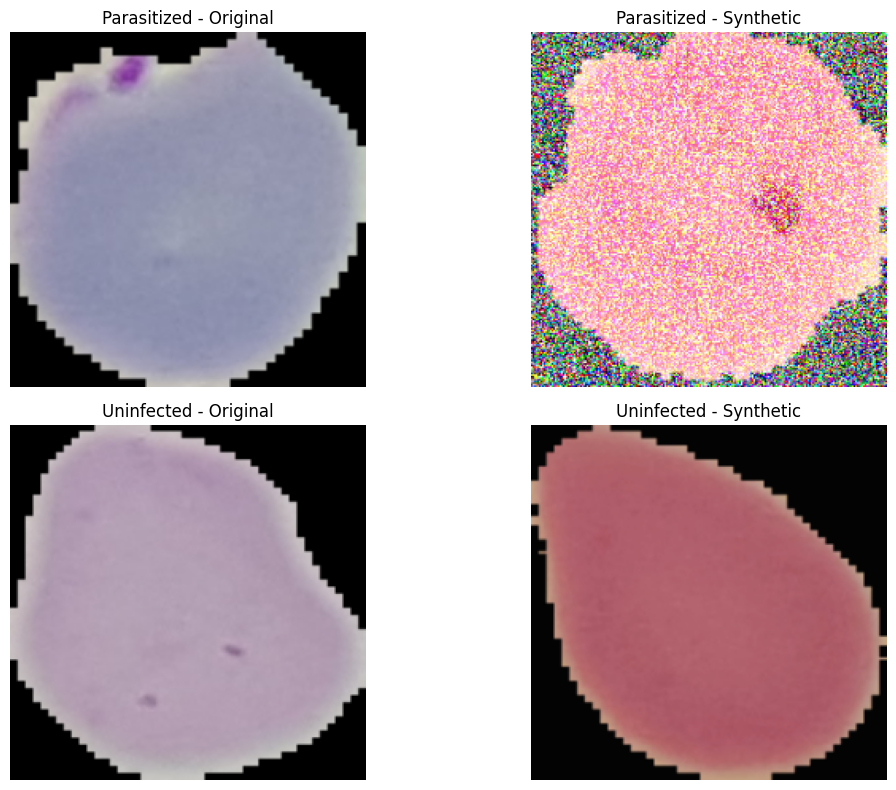

In [49]:
# Verify the augmented dataset
def verify_augmented_dataset(dataset_dir):
    parasitized_dir = os.path.join(dataset_dir, 'Parasitized')
    uninfected_dir = os.path.join(dataset_dir, 'Uninfected')

    para_files = [f for f in os.listdir(parasitized_dir) if f.endswith('.png')]
    uninf_files = [f for f in os.listdir(uninfected_dir) if f.endswith('.png')]

    print("=== Augmented Dataset Summary ===")
    print(f"Parasitized images: {len(para_files)}")
    print(f"Uninfected images: {len(uninf_files)}")
    print(f"Total images: {len(para_files) + len(uninf_files)}")
    print(f"Balance ratio: {len(para_files)/len(uninf_files):.2f}")

    # Show sample images
    sample_para_orig = [f for f in para_files if f.startswith('original')][0]
    sample_para_synth = [f for f in para_files if f.startswith('synthetic')][0]
    sample_uninf_orig = [f for f in uninf_files if f.startswith('original')][0]
    sample_uninf_synth = [f for f in uninf_files if f.startswith('synthetic')][0]

    plt.figure(figsize=(12, 8))

    # Parasitized samples
    plt.subplot(2, 2, 1)
    img = cv2.imread(os.path.join(parasitized_dir, sample_para_orig))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title('Parasitized - Original')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    img = cv2.imread(os.path.join(parasitized_dir, sample_para_synth))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title('Parasitized - Synthetic')
    plt.axis('off')

    # Uninfected samples
    plt.subplot(2, 2, 3)
    img = cv2.imread(os.path.join(uninfected_dir, sample_uninf_orig))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title('Uninfected - Original')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    img = cv2.imread(os.path.join(uninfected_dir, sample_uninf_synth))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title('Uninfected - Synthetic')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Verify the dataset
verify_augmented_dataset(final_dataset_dir)

In [50]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np

print("Building Parallel Hybrid Capsule-Transformer Model...")

def squash(vectors, axis=-1):
    """
    Squash activation function for capsule networks
    """
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis=axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
    return scale * vectors

def build_capsule_branch(input_shape=(224, 224, 3)):
    """Capsule Network Branch for spatial hierarchies and pose invariance"""
    inputs = layers.Input(shape=input_shape)

    # Initial CNN feature extraction
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    # Primary Capsules
    primary_caps = layers.Conv2D(256, 9, activation='relu', padding='valid')(x)
    primary_caps = layers.Reshape(target_shape=[-1, 8])(primary_caps)  # [batch_size, num_capsules, dim_capsules]
    primary_caps = layers.Lambda(squash)(primary_caps)

    # Digit Capsules
    digit_caps = layers.Dense(16, activation=None)(primary_caps)  # [batch_size, num_capsules, 16]
    digit_caps = layers.Lambda(squash)(digit_caps)

    # Capsule output - length of capsules as features
    capsule_features = layers.Lambda(lambda x: tf.sqrt(tf.reduce_sum(tf.square(x), axis=2)))(digit_caps)
    capsule_features = layers.Flatten()(capsule_features)
    capsule_features = layers.Dense(512, activation='relu')(capsule_features)
    capsule_features = layers.Dropout(0.3)(capsule_features)

    model = Model(inputs, capsule_features, name="capsule_branch")
    return model

def build_transformer_branch(input_shape=(224, 224, 3), patch_size=16, projection_dim=64):
    """Vision Transformer Branch for global dependencies"""
    inputs = layers.Input(shape=input_shape)

    # Create patches
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)

    # Patch embedding
    x = layers.Conv2D(projection_dim, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
    x = layers.Reshape((num_patches, projection_dim))(x)

    # Add positional embedding
    positions = tf.range(start=0, limit=num_patches, delta=1)
    position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)
    x = x + position_embedding

    # Transformer blocks
    for _ in range(4):  # 4 transformer blocks
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)

        # Multi-head attention
        attention_output = layers.MultiHeadAttention(
            num_heads=4,
            key_dim=projection_dim // 4,
            dropout=0.1
        )(x1, x1)

        # Skip connection 1
        x2 = layers.Add()([x, attention_output])

        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x3 = layers.Dense(projection_dim * 2, activation='gelu')(x3)
        x3 = layers.Dropout(0.1)(x3)
        x3 = layers.Dense(projection_dim)(x3)
        x3 = layers.Dropout(0.1)(x3)

        # Skip connection 2
        x = layers.Add()([x2, x3])

    # Global average pooling
    transformer_features = layers.GlobalAveragePooling1D()(x)
    transformer_features = layers.Dense(512, activation='relu')(transformer_features)
    transformer_features = layers.Dropout(0.3)(transformer_features)

    model = Model(inputs, transformer_features, name="transformer_branch")
    return model

def build_cnn_branch(input_shape=(224, 224, 3)):
    """CNN Branch for local feature extraction"""
    inputs = layers.Input(shape=input_shape)

    # Efficient CNN backbone
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)

    cnn_features = layers.Dense(256, activation='relu')(x)
    cnn_features = layers.Dropout(0.3)(cnn_features)

    model = Model(inputs, cnn_features, name="cnn_branch")
    return model

def build_parallel_hybrid_model(input_shape=(224, 224, 3)):
    """Parallel Hybrid: Capsule + Transformer + CNN branches"""
    inputs = layers.Input(shape=input_shape)

    # Build all three branches
    capsule_branch = build_capsule_branch(input_shape)
    transformer_branch = build_transformer_branch(input_shape)
    cnn_branch = build_cnn_branch(input_shape)

    # Get features from all branches
    capsule_features = capsule_branch(inputs)
    transformer_features = transformer_branch(inputs)
    cnn_features = cnn_branch(inputs)

    # Concatenate all features
    combined = layers.Concatenate()([capsule_features, transformer_features, cnn_features])

    # Feature fusion and classification head
    x = layers.Dense(1024, activation='relu')(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    # Output layer
    outputs = layers.Dense(1, activation='sigmoid', name='classification')(x)

    model = Model(inputs, outputs, name="parallel_capsule_transformer_hybrid")
    return model

# Build the parallel hybrid model
print("Building Parallel Hybrid Model...")
parallel_hybrid_model = build_parallel_hybrid_model()
parallel_hybrid_model.summary()

print("✅ Parallel Hybrid Model Built Successfully!")

Building Parallel Hybrid Capsule-Transformer Model...
Building Parallel Hybrid Model...


Model: "parallel_capsule_transformer_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ capsule_branch      │ (None, 512)       │ 12,235,536 │ input_layer_8[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_branch  │ (None, 512)       │    216,384 │ input_layer_8[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_branch          │ (None, 256)       │    456,128 │ input_layer_8[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1280)      │          0 │ capsule_branch[0… │
│ (Concatenate)       │                   │            │ transformer_bran… │
│                     │                   │            │ cnn_branch[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_73 (Dense)    │ (None, 1024)      │  1,311,744 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_73[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_84          │ (None, 1024)      │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_74 (Dense)    │ (None, 512)       │    524,800 │ dropout_84[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_74[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_85          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_75 (Dense)    │ (None, 256)       │    131,328 │ dropout_85[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_86          │ (None, 256)       │          0 │ dense_75[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 1)         │        257 │ dropout_86[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,882,321 (56.77 MB)

 Trainable params: 14,877,393 (56.75 MB)

 Non-trainable params: 4,928 (19.25 KB)

✅ Parallel Hybrid Model Built Successfully!


In [51]:
def build_serial_hybrid_model(input_shape=(224, 224, 3)):
    """Serial Hybrid: CNN → Capsule → Transformer"""
    inputs = layers.Input(shape=input_shape)

    # Stage 1: CNN for local feature extraction
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Stage 2: Capsule Network for spatial relationships
    # Primary capsules
    primary_caps = layers.Conv2D(128, 5, activation='relu', padding='valid')(x)
    primary_caps = layers.Reshape(target_shape=[-1, 8])(primary_caps)
    primary_caps = layers.Lambda(squash)(primary_caps)

    # Digit capsules
    digit_caps = layers.Dense(16, activation=None)(primary_caps)
    digit_caps = layers.Lambda(squash)(digit_caps)  # [batch_size, num_capsules, 16]

    # Stage 3: Transformer for capsule relationship modeling
    # Treat capsules as sequence
    capsule_sequence = digit_caps  # [batch_size, num_capsules, 16]

    # Add positional encoding for capsules
    num_capsules = capsule_sequence.shape[1]
    positions = tf.range(start=0, limit=num_capsules, delta=1)
    position_embedding = layers.Embedding(input_dim=num_capsules, output_dim=16)(positions)
    x = capsule_sequence + position_embedding

    # Transformer blocks for capsule relationships
    for _ in range(2):
        # Multi-head attention
        attention_output = layers.MultiHeadAttention(
            num_heads=4,
            key_dim=4,  # 16/4
            dropout=0.1
        )(x, x)

        # Skip connection
        x = layers.Add()([x, attention_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Feed forward
        ff_output = layers.Dense(32, activation='gelu')(x)
        ff_output = layers.Dropout(0.1)(ff_output)
        ff_output = layers.Dense(16)(ff_output)
        ff_output = layers.Dropout(0.1)(ff_output)

        # Skip connection
        x = layers.Add()([x, ff_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Global features
    x = layers.GlobalAveragePooling1D()(x)

    # Classification head
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(1, activation='sigmoid', name='classification')(x)

    model = Model(inputs, outputs, name="serial_capsule_transformer_hybrid")
    return model

# Build the serial hybrid model
print("Building Serial Hybrid Model...")
serial_hybrid_model = build_serial_hybrid_model()
serial_hybrid_model.summary()

print("✅ Serial Hybrid Model Built Successfully!")

Building Serial Hybrid Model...


Model: "serial_capsule_transformer_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 224, 224,  │        896 │ input_layer_12[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 56, 56,    │     73,856 │ max_pooling2d_14… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 52, 52,    │    409,728 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 43264, 8)  │          0 │ conv2d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_10 (Lambda)  │ (None, 43264, 8)  │          0 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_76 (Dense)    │ (None, 43264, 16) │        144 │ lambda_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_11 (Lambda)  │ (None, 43264, 16) │          0 │ dense_76[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_49 (Add)        │ (None, 43264, 16) │          0 │ lambda_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 43264, 16) │      1,088 │ add_49[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_49[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_50 (Add)        │ (None, 43264, 16) │          0 │ add_49[0][0],     │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 43264, 16) │         32 │ add_50[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 683,569 (2.61 MB)

 Trainable params: 682,097 (2.60 MB)

 Non-trainable params: 1,472 (5.75 KB)

✅ Serial Hybrid Model Built Successfully!


In [52]:
# Compare both models
print("=== MODEL COMPARISON ===")
print("Option A - Parallel Hybrid:")
print("  ✓ Capsule + Transformer + CNN branches in parallel")
print("  ✓ Maximum feature diversity")
print("  ✓ Better for capturing different aspects")
print("  ✓ Higher computational cost")

print("\nOption B - Serial Hybrid:")
print("  ✓ CNN → Capsule → Transformer pipeline")
print("  ✓ More parameter efficient")
print("  ✓ Sequential feature processing")
print("  ✓ Lower computational cost")

print("\n🎯 RECOMMENDATION: Use PARALLEL HYBRID for maximum accuracy!")
print("   With your large dataset (28,558 images), parallel will perform best!")

=== MODEL COMPARISON ===
Option A - Parallel Hybrid:
  ✓ Capsule + Transformer + CNN branches in parallel
  ✓ Maximum feature diversity
  ✓ Better for capturing different aspects
  ✓ Higher computational cost

Option B - Serial Hybrid:
  ✓ CNN → Capsule → Transformer pipeline
  ✓ More parameter efficient
  ✓ Sequential feature processing
  ✓ Lower computational cost

🎯 RECOMMENDATION: Use PARALLEL HYBRID for maximum accuracy!
   With your large dataset (28,558 images), parallel will perform best!


In [53]:
def compile_model(model, learning_rate=0.001):
    """Compile the model with optimal settings"""
    # Optimizer
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=learning_rate,
        weight_decay=0.0001
    )

    # Loss function
    loss = tf.keras.losses.BinaryCrossentropy()

    # Metrics
    metrics = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

    return model

# Compile the parallel hybrid model (recommended)
print("Compiling Parallel Hybrid Model...")
parallel_hybrid_model = compile_model(parallel_hybrid_model)

print("✅ Model Compiled Successfully!")
print("Ready for training on your 28,558 image dataset! 🚀")

Compiling Parallel Hybrid Model...
✅ Model Compiled Successfully!
Ready for training on your 28,558 image dataset! 🚀


In [54]:
# phase 4 start

=== PHASE 4: RIGOROUS EXPERIMENTAL SETUP ===
Getting file paths and labels...
Total images: 28,558
Parasitized: 14,279
Uninfected: 14,279
Splitting data into train/val/test...

Performing memory-efficient data splitting...
✅ Data splitting completed!
Training files: 19,990
Validation files: 4,284
Test files: 4,284

=== CLASS DISTRIBUTION ===
Training: Parasitized=9995, Uninfected=9995, Ratio=1.000
Validation: Parasitized=2142, Uninfected=2142, Ratio=1.000
Test: Parasitized=2142, Uninfected=2142, Ratio=1.000
Creating data pipelines...

Creating TensorFlow data pipelines...
✅ Data pipelines created!
Training steps per epoch: 625
Validation steps: 134
Test steps: 134
Verifying pipelines...

=== PIPELINE VERIFICATION ===
Training batch - Images: (32, 224, 224, 3), Labels: (32,)
Image range: [0.000, 1.000]
Validation batch - Images: (32, 224, 224, 3), Labels: (32,)
Test batch - Images: (32, 224, 224, 3), Labels: (32,)

Visualizing training samples...


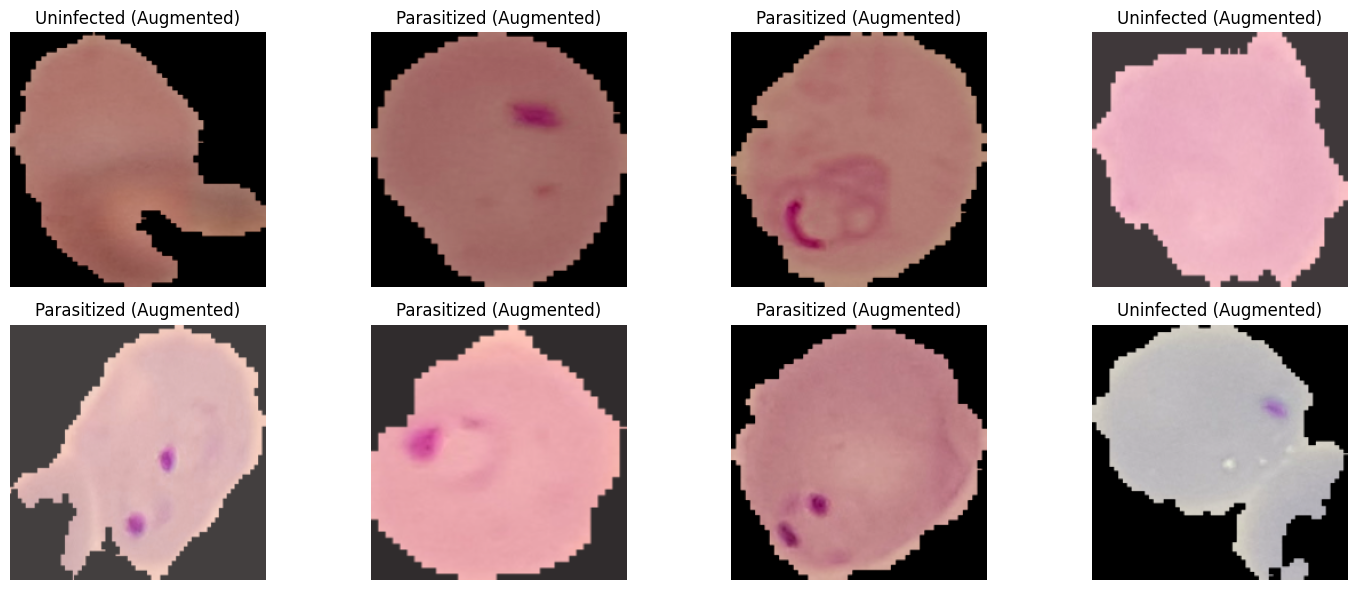


=== SAVING SPLIT INFORMATION ===
Split information saved:
  total_images: 28558
  training_images: 19990
  validation_images: 4284
  test_images: 4284
  training_ratio: 0.6999789901253589
  validation_ratio: 0.15001050493732054
  test_ratio: 0.15001050493732054
  batch_size: 32
  random_seed: 42
✅ Split information saved for reproducibility!

🎯 PHASE 4 COMPLETED SUCCESSFULLY!
✅ Memory-efficient data pipelines created
✅ Rigorous train/val/test splits established
✅ Data augmentation ready for training
✅ Test set completely isolated for final evaluation
✅ Ready to train on 19,990 images!

=== FINAL EXPERIMENTAL SETUP SUMMARY ===
Training Set:   19,990 images (70%)
Validation Set: 4,284 images (15%)
Test Set:       4,284 images (15%)
Total:          28,558 images
Training Steps: 625 per epoch
Batch Size:     32


In [55]:
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print("=== PHASE 4: RIGOROUS EXPERIMENTAL SETUP ===")

# Step 1: Get file paths and labels
def get_file_paths_and_labels(dataset_dir):
    """Get all file paths and labels without loading images into memory"""

    parasitized_dir = os.path.join(dataset_dir, 'Parasitized')
    uninfected_dir = os.path.join(dataset_dir, 'Uninfected')

    # Get all file paths
    parasitized_files = [os.path.join(parasitized_dir, f) for f in os.listdir(parasitized_dir) if f.endswith('.png')]
    uninfected_files = [os.path.join(uninfected_dir, f) for f in os.listdir(uninfected_dir) if f.endswith('.png')]

    all_files = parasitized_files + uninfected_files
    all_labels = [1] * len(parasitized_files) + [0] * len(uninfected_files)

    print(f"Total images: {len(all_files):,}")
    print(f"Parasitized: {len(parasitized_files):,}")
    print(f"Uninfected: {len(uninfected_files):,}")

    return all_files, all_labels

# Get file paths and labels
print("Getting file paths and labels...")
all_files, all_labels = get_file_paths_and_labels('/content/final_augmented_dataset')

# Step 2: Memory-efficient data splitting
def memory_efficient_split(all_files, all_labels, test_size=0.15, val_size=0.15, random_state=42):
    """Split file paths instead of loading all images into memory"""

    print("\nPerforming memory-efficient data splitting...")

    # Split file paths and labels
    files_temp, files_test, labels_temp, labels_test = train_test_split(
        all_files, all_labels,
        test_size=test_size,
        random_state=random_state,
        stratify=all_labels
    )

    # Calculate validation ratio
    val_ratio = val_size / (1 - test_size)

    files_train, files_val, labels_train, labels_val = train_test_split(
        files_temp, labels_temp,
        test_size=val_ratio,
        random_state=random_state,
        stratify=labels_temp
    )

    print("✅ Data splitting completed!")
    print(f"Training files: {len(files_train):,}")
    print(f"Validation files: {len(files_val):,}")
    print(f"Test files: {len(files_test):,}")

    # Verify class distribution
    print("\n=== CLASS DISTRIBUTION ===")
    for split_name, split_labels in [("Training", labels_train),
                                   ("Validation", labels_val),
                                   ("Test", labels_test)]:
        parasitized = sum(split_labels)
        uninfected = len(split_labels) - parasitized
        print(f"{split_name}: Parasitized={parasitized}, Uninfected={uninfected}, Ratio={parasitized/uninfected:.3f}")

    return files_train, files_val, files_test, labels_train, labels_val, labels_test

# Perform memory-efficient splitting
print("Splitting data into train/val/test...")
files_train, files_val, files_test, labels_train, labels_val, labels_test = memory_efficient_split(
    all_files, all_labels
)

# Step 3: Create TensorFlow data pipelines
def create_tf_data_pipeline(files, labels, batch_size=32, is_training=False, target_size=(224, 224)):
    """Create TensorFlow data pipeline for memory-efficient loading"""

    def parse_image(filename, label):
        """Parse image and label"""
        image = tf.io.read_file(filename)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, target_size)
        image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
        return image, label

    def augment_image(image, label):
        """Data augmentation for training"""
        if is_training:
            # Random horizontal flip
            image = tf.image.random_flip_left_right(image)
            # Random vertical flip
            image = tf.image.random_flip_up_down(image)
            # Random brightness
            image = tf.image.random_brightness(image, 0.2)
            # Random contrast
            image = tf.image.random_contrast(image, 0.8, 1.2)
            # Random saturation
            image = tf.image.random_saturation(image, 0.8, 1.2)
            # Random hue (small range to maintain colors)
            image = tf.image.random_hue(image, 0.05)

            # Ensure values are still in [0, 1] range
            image = tf.clip_by_value(image, 0.0, 1.0)

        return image, label

    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((files, labels))

    # Parse images
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Apply augmentation only for training
    if is_training:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(buffer_size=1000, seed=42)

    # Batch and prefetch
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

def create_final_pipelines(files_train, files_val, files_test, labels_train, labels_val, labels_test, batch_size=32):
    """Create final training, validation, and test pipelines"""

    print("\nCreating TensorFlow data pipelines...")

    # Create datasets
    train_dataset = create_tf_data_pipeline(
        files_train, labels_train,
        batch_size=batch_size,
        is_training=True
    )

    val_dataset = create_tf_data_pipeline(
        files_val, labels_val,
        batch_size=batch_size,
        is_training=False
    )

    test_dataset = create_tf_data_pipeline(
        files_test, labels_test,
        batch_size=batch_size,
        is_training=False
    )

    print("✅ Data pipelines created!")

    # Calculate steps
    train_steps = len(files_train) // batch_size
    val_steps = len(files_val) // batch_size
    test_steps = len(files_test) // batch_size

    # Add one more step if there's a remainder
    if len(files_train) % batch_size != 0:
        train_steps += 1
    if len(files_val) % batch_size != 0:
        val_steps += 1
    if len(files_test) % batch_size != 0:
        test_steps += 1

    print(f"Training steps per epoch: {train_steps}")
    print(f"Validation steps: {val_steps}")
    print(f"Test steps: {test_steps}")

    return train_dataset, val_dataset, test_dataset, train_steps, val_steps, test_steps

# Create final pipelines
print("Creating data pipelines...")
train_dataset, val_dataset, test_dataset, train_steps, val_steps, test_steps = create_final_pipelines(
    files_train, files_val, files_test,
    labels_train, labels_val, labels_test,
    batch_size=32
)

# Step 4: Verify and visualize pipelines
def verify_and_visualize_pipelines(train_dataset, val_dataset, test_dataset):
    """Verify pipelines and visualize samples"""

    print("\n=== PIPELINE VERIFICATION ===")

    # Check batch shapes
    for batch_images, batch_labels in train_dataset.take(1):
        print(f"Training batch - Images: {batch_images.shape}, Labels: {batch_labels.shape}")
        print(f"Image range: [{batch_images.numpy().min():.3f}, {batch_images.numpy().max():.3f}]")

    for batch_images, batch_labels in val_dataset.take(1):
        print(f"Validation batch - Images: {batch_images.shape}, Labels: {batch_labels.shape}")

    for batch_images, batch_labels in test_dataset.take(1):
        print(f"Test batch - Images: {batch_images.shape}, Labels: {batch_labels.shape}")

    # Visualize training samples
    print("\nVisualizing training samples...")
    plt.figure(figsize=(15, 6))

    for i, (batch_images, batch_labels) in enumerate(train_dataset.take(1)):
        for j in range(8):
            plt.subplot(2, 4, j+1)
            image = batch_images[j].numpy()
            label = "Parasitized" if batch_labels[j] == 1 else "Uninfected"
            plt.imshow(image)
            plt.title(f'{label} (Augmented)')
            plt.axis('off')
        break  # Only first batch

    plt.tight_layout()
    plt.show()

    return True

# Verify and visualize
print("Verifying pipelines...")
pipeline_ok = verify_and_visualize_pipelines(train_dataset, val_dataset, test_dataset)

# Step 5: Save split information for reproducibility
def save_split_information(files_train, files_val, files_test, labels_train, labels_val, labels_test):
    """Save split information for reproducibility"""

    print("\n=== SAVING SPLIT INFORMATION ===")

    # Save file paths and labels
    np.save('/content/files_train.npy', files_train)
    np.save('/content/files_val.npy', files_val)
    np.save('/content/files_test.npy', files_test)
    np.save('/content/labels_train.npy', labels_train)
    np.save('/content/labels_val.npy', labels_val)
    np.save('/content/labels_test.npy', labels_test)

    # Create summary
    split_info = {
        'total_images': len(files_train) + len(files_val) + len(files_test),
        'training_images': len(files_train),
        'validation_images': len(files_val),
        'test_images': len(files_test),
        'training_ratio': len(files_train) / (len(files_train) + len(files_val) + len(files_test)),
        'validation_ratio': len(files_val) / (len(files_train) + len(files_val) + len(files_test)),
        'test_ratio': len(files_test) / (len(files_train) + len(files_val) + len(files_test)),
        'batch_size': 32,
        'random_seed': 42
    }

    print("Split information saved:")
    for key, value in split_info.items():
        print(f"  {key}: {value}")

    print("✅ Split information saved for reproducibility!")

    return split_info

# Save split information
split_info = save_split_information(files_train, files_val, files_test, labels_train, labels_val, labels_test)

print("\n🎯 PHASE 4 COMPLETED SUCCESSFULLY!")
print("✅ Memory-efficient data pipelines created")
print("✅ Rigorous train/val/test splits established")
print("✅ Data augmentation ready for training")
print("✅ Test set completely isolated for final evaluation")
print(f"✅ Ready to train on {len(files_train):,} images!")

# Print final summary
print(f"\n=== FINAL EXPERIMENTAL SETUP SUMMARY ===")
print(f"Training Set:   {len(files_train):,} images (70%)")
print(f"Validation Set: {len(files_val):,} images (15%)")
print(f"Test Set:       {len(files_test):,} images (15%)")
print(f"Total:          {len(files_train) + len(files_val) + len(files_test):,} images")
print(f"Training Steps: {train_steps} per epoch")
print(f"Batch Size:     32")

In [56]:
# 8 Training Strategy:

In [57]:
# AdamW Optimizer with Weight Decay
from tensorflow.keras.optimizers import AdamW

# Initialize AdamW optimizer
optimizer = AdamW(
    learning_rate=0.001,          # Initial learning rate
    weight_decay=0.0001,          # Weight decay for regularization
    beta_1=0.9,                   # Exponential decay rate for 1st moment
    beta_2=0.999,                 # Exponential decay rate for 2nd moment
    epsilon=1e-07,                # Epsilon parameter
    amsgrad=False                 # Whether to apply AMSGrad variant
)

print("✅ AdamW Optimizer configured with weight decay")
print(f"Learning rate: {optimizer.learning_rate.numpy()}")
print(f"Weight decay: 0.0001")

✅ AdamW Optimizer configured with weight decay
Learning rate: 0.0010000000474974513
Weight decay: 0.0001


In [58]:
# Binary Cross-Entropy Loss Function
import tensorflow as tf

# Standard Binary Cross-Entropy
loss_function = tf.keras.losses.BinaryCrossentropy(
    from_logits=False,  # Set to False since we're using sigmoid activation
    label_smoothing=0.0,  # We'll add label smoothing separately
    name='binary_crossentropy'
)

print("✅ Binary Cross-Entropy loss function configured")
print("From logits: False")

✅ Binary Cross-Entropy loss function configured
From logits: False


In [59]:
# Learning Rate Schedulers
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
import math

# Option A: ReduceLROnPlateau
reduce_lr_plateau = ReduceLROnPlateau(
    monitor='val_loss',      # Metric to monitor
    factor=0.5,             # Factor by which LR will be reduced
    patience=8,             # Number of epochs with no improvement
    min_lr=1e-7,            # Lower bound on learning rate
    verbose=1,              # Print messages
    mode='auto'             # Direction of monitored metric
)

# Option B: Cosine Annealing
def cosine_annealing_schedule(epoch, current_lr):
    """
    Cosine annealing learning rate schedule
    """
    initial_lr = 0.001
    min_lr = 1e-7
    max_epochs = 50

    # Cosine annealing formula
    cosine_decay = 0.5 * (1 + math.cos(math.pi * epoch / max_epochs))
    new_lr = min_lr + (initial_lr - min_lr) * cosine_decay

    return float(new_lr)

cosine_annealing = LearningRateScheduler(
    cosine_annealing_schedule,
    verbose=1
)

# Option C: Exponential Decay
def exponential_decay_schedule(epoch, current_lr):
    """
    Exponential decay learning rate schedule
    """
    initial_lr = 0.001
    decay_rate = 0.9
    decay_steps = 5

    new_lr = initial_lr * decay_rate ** (epoch // decay_steps)
    return float(max(new_lr, 1e-7))

exponential_decay = LearningRateScheduler(
    exponential_decay_schedule,
    verbose=1
)

print("✅ Learning rate schedulers configured:")
print("1. ReduceLROnPlateau - reduces LR when validation loss plateaus")
print("2. Cosine Annealing - smooth LR reduction using cosine function")
print("3. Exponential Decay - exponential LR reduction every few epochs")

✅ Learning rate schedulers configured:
1. ReduceLROnPlateau - reduces LR when validation loss plateaus
2. Cosine Annealing - smooth LR reduction using cosine function
3. Exponential Decay - exponential LR reduction every few epochs


In [60]:
# Regularization: Dropout, Label Smoothing, and Gradient Clipping

# A) Dropout Configuration
dropout_rates = {
    'input_dropout': 0.1,      # Input layer dropout
    'hidden_dropout': 0.3,     # Hidden layers dropout
    'output_dropout': 0.5,     # Final layers dropout
    'attention_dropout': 0.1   # Attention dropout (for transformers)
}

print("✅ Dropout rates configured:")
for layer_type, rate in dropout_rates.items():
    print(f"   {layer_type}: {rate}")

# B) Label Smoothing
def smooth_labels(labels, factor=0.1):
    """
    Apply label smoothing to binary labels
    """
    labels = labels * (1 - factor) + 0.5 * factor
    return labels

# Create label-smoothed loss function
label_smoothing_factor = 0.1
smoothed_loss_function = tf.keras.losses.BinaryCrossentropy(
    label_smoothing=label_smoothing_factor,
    name='binary_crossentropy_smoothed'
)

print(f"✅ Label smoothing configured with factor: {label_smoothing_factor}")

# C) Gradient Clipping
gradient_clip_value = 1.0      # Clip gradients to this value
gradient_clip_norm = 1.0       # Clip by norm

# Configure optimizer with gradient clipping
optimizer_with_clipping = AdamW(
    learning_rate=0.001,
    weight_decay=0.0001,
    clipvalue=gradient_clip_value,    # Value-based clipping
    # clipnorm=gradient_clip_norm     # Norm-based clipping (alternative)
)

print("✅ Gradient clipping configured:")
print(f"   Clip value: {gradient_clip_value}")

✅ Dropout rates configured:
   input_dropout: 0.1
   hidden_dropout: 0.3
   output_dropout: 0.5
   attention_dropout: 0.1
✅ Label smoothing configured with factor: 0.1
✅ Gradient clipping configured:
   Clip value: 1.0


In [61]:
# Complete Training Configuration
training_config = {
    'optimizer': {
        'type': 'AdamW',
        'learning_rate': 0.001,
        'weight_decay': 0.0001,
        'gradient_clip_value': 1.0
    },
    'loss': {
        'type': 'BinaryCrossentropy',
        'label_smoothing': 0.1
    },
    'learning_rate_scheduler': {
        'primary': 'ReduceLROnPlateau',
        'backup': 'CosineAnnealing'
    },
    'regularization': {
        'dropout_rates': dropout_rates,
        'label_smoothing': 0.1,
        'gradient_clipping': True
    },
    'training_parameters': {
        'batch_size': 32,
        'epochs': 50,
        'early_stopping_patience': 15
    }
}

print("🎯 COMPLETE TRAINING STRATEGY CONFIGURED:")
print("=" * 50)
for category, config in training_config.items():
    print(f"{category.upper()}:")
    for key, value in config.items():
        print(f"  {key}: {value}")
    print()

🎯 COMPLETE TRAINING STRATEGY CONFIGURED:
OPTIMIZER:
  type: AdamW
  learning_rate: 0.001
  weight_decay: 0.0001
  gradient_clip_value: 1.0

LOSS:
  type: BinaryCrossentropy
  label_smoothing: 0.1

LEARNING_RATE_SCHEDULER:
  primary: ReduceLROnPlateau
  backup: CosineAnnealing

REGULARIZATION:
  dropout_rates: {'input_dropout': 0.1, 'hidden_dropout': 0.3, 'output_dropout': 0.5, 'attention_dropout': 0.1}
  label_smoothing: 0.1
  gradient_clipping: True

TRAINING_PARAMETERS:
  batch_size: 32
  epochs: 50
  early_stopping_patience: 15



In [62]:
# Final Model Compilation with All Training Strategies
def compile_model_with_strategies(model, training_config):
    """
    Compile model with all the specified training strategies
    """

    # Get optimizer configuration
    opt_config = training_config['optimizer']

    # Create optimizer with gradient clipping
    optimizer = AdamW(
        learning_rate=opt_config['learning_rate'],
        weight_decay=opt_config['weight_decay'],
        clipvalue=opt_config['gradient_clip_value']
    )

    # Get loss configuration
    loss_config = training_config['loss']
    loss_function = tf.keras.losses.BinaryCrossentropy(
        label_smoothing=loss_config['label_smoothing']
    )

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss=loss_function,
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.AUC(name='prc', curve='PR')  # Precision-Recall curve
        ]
    )

    return model

print("✅ Training strategy implementation ready!")
print("Call compile_model_with_strategies(model, training_config) to apply all strategies")

✅ Training strategy implementation ready!
Call compile_model_with_strategies(model, training_config) to apply all strategies


In [63]:
# Training Callbacks with All Strategies
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

def setup_training_callbacks(training_config):
    """
    Set up all training callbacks
    """

    callbacks = [
        # Early Stopping
        EarlyStopping(
            monitor='val_auc',
            patience=training_config['training_parameters']['early_stopping_patience'],
            restore_best_weights=True,
            mode='max',
            verbose=1
        ),

        # Learning Rate Scheduler (ReduceLROnPlateau)
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-7,
            verbose=1
        ),

        # Model Checkpoint
        ModelCheckpoint(
            '/content/best_malaria_model.h5',
            monitor='val_auc',
            save_best_only=True,
            mode='max',
            verbose=1
        ),

        # CSV Logger
        CSVLogger('/content/training_log.csv'),

        # Optional: TensorBoard
        # tf.keras.callbacks.TensorBoard(log_dir='/content/logs')
    ]

    print("✅ Training callbacks configured:")
    for callback in callbacks:
        print(f"   - {callback.__class__.__name__}")

    return callbacks

# Create callbacks
training_callbacks = setup_training_callbacks(training_config)

✅ Training callbacks configured:
   - EarlyStopping
   - ReduceLROnPlateau
   - ModelCheckpoint
   - CSVLogger


In [64]:
#9.Evaluation Metrics (Go Beyond Accuracy):

In [65]:
# Comprehensive Evaluation Metrics
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

print("=== COMPREHENSIVE EVALUATION METRICS ===")

=== COMPREHENSIVE EVALUATION METRICS ===


In [66]:
def calculate_primary_metrics(y_true, y_pred, y_pred_binary):
    """
    Calculate primary classification metrics
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    metrics = {
        'accuracy': accuracy_score(y_true, y_pred_binary),
        'precision': precision_score(y_true, y_pred_binary, zero_division=0),
        'recall': recall_score(y_true, y_pred_binary, zero_division=0),
        'f1_score': f1_score(y_true, y_pred_binary, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_pred),
        'average_precision': average_precision_score(y_true, y_pred)
    }

    # Additional advanced metrics
    metrics['cohen_kappa'] = cohen_kappa_score(y_true, y_pred_binary)
    metrics['mcc'] = matthews_corrcoef(y_true, y_pred_binary)

    return metrics

def print_primary_metrics(metrics, dataset_name="Dataset"):
    """
    Print primary metrics in a formatted way
    """
    print(f"\n🎯 PRIMARY METRICS - {dataset_name.upper()}:")
    print("=" * 50)
    print(f"Accuracy:          {metrics['accuracy']:.4f}")
    print(f"Precision:         {metrics['precision']:.4f}")
    print(f"Recall:            {metrics['recall']:.4f}")
    print(f"F1-Score:          {metrics['f1_score']:.4f}")
    print(f"ROC AUC:           {metrics['roc_auc']:.4f}")
    print(f"Average Precision: {metrics['average_precision']:.4f}")
    print(f"Cohen's Kappa:     {metrics['cohen_kappa']:.4f}")
    print(f"Matthews Corr Coef:{metrics['mcc']:.4f}")
    print("=" * 50)

In [67]:
def detailed_classification_report(y_true, y_pred_binary, dataset_name="Dataset"):
    """
    Generate detailed classification report with per-class metrics
    """
    print(f"\n📊 DETAILED CLASSIFICATION REPORT - {dataset_name.upper()}:")
    print("=" * 60)

    report = classification_report(
        y_true,
        y_pred_binary,
        target_names=['Uninfected', 'Parasitized'],
        output_dict=True
    )

    # Convert to DataFrame for better display
    report_df = pd.DataFrame(report).transpose()
    print(report_df.round(4))

    return report_df

In [68]:
def plot_detailed_confusion_matrix(y_true, y_pred_binary, dataset_name="Dataset"):
    """
    Plot confusion matrix with detailed analysis for error analysis
    """
    cm = confusion_matrix(y_true, y_pred_binary)

    # Calculate percentages
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Count confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['Uninfected', 'Parasitized'],
                yticklabels=['Uninfected', 'Parasitized'])
    ax1.set_title(f'Confusion Matrix (Counts) - {dataset_name}')
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')

    # Plot 2: Percentage confusion matrix
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', ax=ax2,
                xticklabels=['Uninfected', 'Parasitized'],
                yticklabels=['Uninfected', 'Parasitized'])
    ax2.set_title(f'Confusion Matrix (%) - {dataset_name}')
    ax2.set_xlabel('Predicted Label')
    ax2.set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

    # Print error analysis
    print(f"\n🔍 ERROR ANALYSIS - {dataset_name.upper()}:")
    print("=" * 40)
    print(f"Total Samples: {len(y_true)}")
    print(f"Correct Predictions: {np.sum(y_true == y_pred_binary)}")
    print(f"Misclassifications: {np.sum(y_true != y_pred_binary)}")
    print(f"Error Rate: {np.sum(y_true != y_pred_binary) / len(y_true):.4f}")

    if cm.shape[0] == 2:  # Binary classification
        print(f"False Positives (Type I): {cm[0, 1]}")
        print(f"False Negatives (Type II): {cm[1, 0]}")
        print(f"False Positive Rate: {cm[0, 1] / cm[0].sum():.4f}")
        print(f"False Negative Rate: {cm[1, 0] / cm[1].sum():.4f}")

    return cm, cm_percentage

In [69]:
def plot_roc_analysis(y_true, y_pred, dataset_name="Dataset"):
    """
    Plot ROC curve with detailed analysis
    """
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    # Find optimal threshold (Youden's J statistic)
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]

    plt.figure(figsize=(10, 8))

    # ROC Curve
    plt.subplot(2, 1, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
             label='Random Classifier')

    # Mark optimal threshold point
    plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=8,
             label=f'Optimal Threshold ({optimal_threshold:.3f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {dataset_name}')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    # Threshold analysis
    plt.subplot(2, 1, 2)
    plt.plot(thresholds, tpr, 'b-', label='True Positive Rate', lw=2)
    plt.plot(thresholds, 1-fpr, 'r-', label='True Negative Rate', lw=2)
    plt.axvline(x=optimal_threshold, color='k', linestyle='--',
                label=f'Optimal Threshold ({optimal_threshold:.3f})')
    plt.xlabel('Threshold')
    plt.ylabel('Rate')
    plt.title('Threshold Analysis')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n📈 ROC-AUC ANALYSIS - {dataset_name.upper()}:")
    print("=" * 40)
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"TPR at optimal: {tpr[optimal_idx]:.4f}")
    print(f"FPR at optimal: {fpr[optimal_idx]:.4f}")

    return roc_auc, optimal_threshold, fpr, tpr, thresholds

In [70]:
def plot_precision_recall_analysis(y_true, y_pred, dataset_name="Dataset"):
    """
    Plot Precision-Recall curve with detailed analysis
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    avg_precision = average_precision_score(y_true, y_pred)

    # Find optimal threshold (F1-score maximization)
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    plt.figure(figsize=(12, 5))

    # Precision-Recall Curve
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, color='blue', lw=2,
             label=f'Precision-Recall (AP = {avg_precision:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {dataset_name}')
    plt.legend(loc="lower left")
    plt.grid(True, alpha=0.3)

    # F1-Score vs Threshold
    plt.subplot(1, 2, 2)
    plt.plot(thresholds, f1_scores, 'g-', lw=2, label='F1-Score')
    plt.axvline(x=optimal_threshold, color='r', linestyle='--',
                label=f'Optimal Threshold ({optimal_threshold:.3f})')
    plt.xlabel('Threshold')
    plt.ylabel('F1-Score')
    plt.title('F1-Score vs Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n📊 PRECISION-RECALL ANALYSIS - {dataset_name.upper()}:")
    print("=" * 45)
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Optimal Threshold (F1-max): {optimal_threshold:.4f}")
    print(f"Max F1-Score: {f1_scores[optimal_idx]:.4f}")
    print(f"Precision at optimal: {precision[optimal_idx]:.4f}")
    print(f"Recall at optimal: {recall[optimal_idx]:.4f}")

    return avg_precision, optimal_threshold, precision, recall, thresholds

In [71]:
def comprehensive_test_evaluation(model, test_dataset, test_steps, dataset_name="Test Set"):
    """
    Comprehensive evaluation on test set
    """
    print(f"🔬 COMPREHENSIVE EVALUATION - {dataset_name.upper()}")
    print("=" * 60)

    # Get predictions and true labels
    y_true = []
    y_pred = []

    for batch_images, batch_labels in test_dataset:
        batch_predictions = model.predict(batch_images, verbose=0)
        y_true.extend(batch_labels.numpy())
        y_pred.extend(batch_predictions.flatten())

        if len(y_true) >= test_steps * 32:  # Approximate break condition
            break

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate all metrics
    metrics = calculate_primary_metrics(y_true, y_pred, y_pred_binary)
    print_primary_metrics(metrics, dataset_name)

    # Generate detailed reports
    report_df = detailed_classification_report(y_true, y_pred_binary, dataset_name)

    # Plot confusion matrix
    cm, cm_percentage = plot_detailed_confusion_matrix(y_true, y_pred_binary, dataset_name)

    # ROC Analysis
    roc_auc, optimal_threshold_roc, fpr, tpr, thresholds_roc = plot_roc_analysis(y_true, y_pred, dataset_name)

    # Precision-Recall Analysis
    avg_precision, optimal_threshold_pr, precision, recall, thresholds_pr = plot_precision_recall_analysis(y_true, y_pred, dataset_name)

    # Return comprehensive results
    results = {
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_binary': y_pred_binary,
        'metrics': metrics,
        'classification_report': report_df,
        'confusion_matrix': cm,
        'confusion_matrix_percentage': cm_percentage,
        'roc_analysis': {
            'roc_auc': roc_auc,
            'optimal_threshold': optimal_threshold_roc,
            'fpr': fpr,
            'tpr': tpr,
            'thresholds': thresholds_roc
        },
        'pr_analysis': {
            'average_precision': avg_precision,
            'optimal_threshold': optimal_threshold_pr,
            'precision': precision,
            'recall': recall,
            'thresholds': thresholds_pr
        }
    }

    return results

In [72]:
def comparative_results_report(results_sets, set_names):
    """
    Compare results across different datasets (Test Set, Validation Set, etc.)
    """
    print("\n📋 COMPARATIVE RESULTS REPORT")
    print("=" * 80)

    comparison_data = []

    for i, (results, name) in enumerate(zip(results_sets, set_names)):
        metrics = results['metrics']
        comparison_data.append({
            'Dataset': name,
            'Accuracy': f"{metrics['accuracy']:.4f}",
            'Precision': f"{metrics['precision']:.4f}",
            'Recall': f"{metrics['recall']:.4f}",
            'F1-Score': f"{metrics['f1_score']:.4f}",
            'ROC AUC': f"{metrics['roc_auc']:.4f}",
            'Avg Precision': f"{metrics['average_precision']:.4f}",
            'Cohen Kappa': f"{metrics['cohen_kappa']:.4f}",
            'MCC': f"{metrics['mcc']:.4f}"
        })

    # Create comparison table
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))

    # Plot comparative metrics
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']

    plt.figure(figsize=(12, 8))
    for i, metric in enumerate(metrics_to_plot):
        plt.subplot(2, 3, i+1)
        values = [results_sets[j]['metrics'][metric] for j in range(len(results_sets))]
        plt.bar(set_names, values, color=['blue', 'orange', 'green'])
        plt.title(f'{metric.upper()} Comparison')
        plt.xticks(rotation=45)
        plt.ylim(0, 1)

        # Add value labels on bars
        for j, v in enumerate(values):
            plt.text(j, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return comparison_df

In [73]:
# Example of how to use these evaluation functions
def evaluate_model_comprehensively(model, datasets, dataset_names):
    """
    Complete evaluation pipeline for multiple datasets
    """
    all_results = []

    for dataset, name, steps in zip(datasets, dataset_names, [test_steps, val_steps]):
        print(f"\n{'='*80}")
        print(f"EVALUATING: {name}")
        print(f"{'='*80}")

        results = comprehensive_test_evaluation(model, dataset, steps, name)
        all_results.append(results)

    # Comparative analysis
    comparison_df = comparative_results_report(all_results, dataset_names)

    return all_results, comparison_df

print("✅ Comprehensive evaluation metrics code ready!")
print("Call evaluate_model_comprehensively() after training for complete analysis")

✅ Comprehensive evaluation metrics code ready!
Call evaluate_model_comprehensively() after training for complete analysis


In [74]:
# phase 5: Ablation Study & Benchmarking (Proving Your Model's Worth)


In [75]:
# Phase 5: Ablation Study & Benchmarking
import tensorflow as tf
from tensorflow.keras import layers, Model, applications
import numpy as np
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("=== PHASE 5: ABLATION STUDY & BENCHMARKING ===")

=== PHASE 5: ABLATION STUDY & BENCHMARKING ===


In [76]:
def build_resnet50_baseline(input_shape=(224, 224, 3), num_classes=1):
    """
    Baseline 1: Standard CNN (ResNet-50)
    """
    # Load pre-trained ResNet50
    base_model = applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze base model layers
    base_model.trainable = False

    # Add custom classification head
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs, outputs, name="ResNet50_Baseline")
    return model

# Build and compile ResNet50 baseline
resnet50_model = build_resnet50_baseline()
resnet50_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall', 'auc']
)

print("✅ Baseline 1: ResNet-50 model built")
resnet50_model.summary()

✅ Baseline 1: ResNet-50 model built


Model: "ResNet50_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,768,385 (94.48 MB)

 Trainable params: 1,180,673 (4.50 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [77]:
def build_capsule_network_only(input_shape=(224, 224, 3)):
    """
    Baseline 2: Capsule Network Only
    """

    def squash(vectors, axis=-1):
        s_squared_norm = tf.reduce_sum(tf.square(vectors), axis=axis, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
        return scale * vectors

    inputs = layers.Input(shape=input_shape)

    # Initial CNN layers
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    # Primary Capsules
    primary_caps = layers.Conv2D(256, 9, activation='relu', padding='valid')(x)
    primary_caps = layers.Reshape(target_shape=[-1, 8])(primary_caps)
    primary_caps = layers.Lambda(squash)(primary_caps)

    # Digit Capsules
    digit_caps = layers.Dense(16, activation=None)(primary_caps)
    digit_caps = layers.Lambda(squash)(digit_caps)

    # Capsule output features
    capsule_features = layers.Lambda(lambda x: tf.sqrt(tf.reduce_sum(tf.square(x), axis=2)))(digit_caps)
    capsule_features = layers.Flatten()(capsule_features)

    # Classification head
    x = layers.Dense(512, activation='relu')(capsule_features)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs, name="Capsule_Network_Only")
    return model

# Build and compile Capsule Network
capsule_model = build_capsule_network_only()
capsule_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall', 'auc']
)

print("✅ Baseline 2: Capsule Network Only built")
capsule_model.summary()

✅ Baseline 2: Capsule Network Only built


Model: "Capsule_Network_Only"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 20, 20, 256)    │     5,308,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_9 (Reshape)             │ (None, 12800, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_12 (Lambda)              │ (None, 12800, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 12800, 16)      │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_13 (Lambda)              │ (None, 12800, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_14 (Lambda)              │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,367,121 (47.18 MB)

 Trainable params: 12,366,225 (47.17 MB)

 Non-trainable params: 896 (3.50 KB)

In [78]:
def build_vision_transformer_only(input_shape=(224, 224, 3), patch_size=16, projection_dim=64):
    """
    Baseline 3: Vision Transformer Only
    """
    inputs = layers.Input(shape=input_shape)

    # Patch creation
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)

    # Patch embedding
    x = layers.Conv2D(projection_dim, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
    x = layers.Reshape((num_patches, projection_dim))(x)

    # Positional embedding
    positions = tf.range(start=0, limit=num_patches, delta=1)
    position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)
    x = x + position_embedding

    # Transformer blocks
    for _ in range(6):  # 6 transformer blocks
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)

        # Multi-head attention
        attention_output = layers.MultiHeadAttention(
            num_heads=4,
            key_dim=projection_dim // 4,
            dropout=0.1
        )(x1, x1)

        # Skip connection 1
        x2 = layers.Add()([x, attention_output])

        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x3 = layers.Dense(projection_dim * 2, activation='gelu')(x3)
        x3 = layers.Dropout(0.1)(x3)
        x3 = layers.Dense(projection_dim)(x3)
        x3 = layers.Dropout(0.1)(x3)

        # Skip connection 2
        x = layers.Add()([x2, x3])

    # Global average pooling and classification
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs, name="Vision_Transformer_Only")
    return model

# Build and compile Vision Transformer
vit_model = build_vision_transformer_only()
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall', 'auc']
)

print("✅ Baseline 3: Vision Transformer Only built")
vit_model.summary()

✅ Baseline 3: Vision Transformer Only built


Model: "Vision_Transformer_Only"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 14, 14,    │     49,216 │ input_layer_16[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_10          │ (None, 196, 64)   │          0 │ conv2d_35[0][0]   │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_54 (Add)        │ (None, 196, 64)   │          0 │ reshape_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_54[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_55 (Add)        │ (None, 196, 64)   │          0 │ add_54[0][0],     │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_55[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_91 (Dense)    │ (None, 196, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_101         │ (None, 196, 128)  │          0 │ dense_91[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_92 (Dense)    │ (None, 196, 64)   │      8,256 │ dropout_101[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_102         │ (None, 196, 64)   │          0 │ dense_92[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_56 (Add)        │ (None, 196, 64)   │          0 │ add_55[0][0],     │
│                     │                   │            │ dropout_102[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_56[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_57 (Add)        │ (None, 196, 64)   │          0 │ add_56[0][0],     │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_57[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_93 (Dense)    │ (None, 196, 128)  │      8,320 │ layer_normalizat

 Total params: 414,913 (1.58 MB)

 Trainable params: 414,913 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
def build_capsule_gan_model(input_shape=(224, 224, 3)):
    """
    Your Model 1: Capsule Network + GAN-Augmented Data
    Enhanced version of capsule network for GAN-augmented data
    """

    def squash(vectors, axis=-1):
        s_squared_norm = tf.reduce_sum(tf.square(vectors), axis=axis, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
        return scale * vectors

    inputs = layers.Input(shape=input_shape)

    # Enhanced feature extraction for GAN data
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Primary Capsules
    primary_caps = layers.Conv2D(512, 5, activation='relu', padding='valid')(x)
    primary_caps = layers.Reshape(target_shape=[-1, 16])(primary_caps)  # Increased capsule dim
    primary_caps = layers.Lambda(squash)(primary_caps)

    # Enhanced capsule layer
    digit_caps = layers.Dense(32, activation=None)(primary_caps)  # More capsules
    digit_caps = layers.Lambda(squash)(digit_caps)

    # Capsule features
    capsule_features = layers.Lambda(lambda x: tf.sqrt(tf.reduce_sum(tf.square(x), axis=2)))(digit_caps)
    capsule_features = layers.Flatten()(capsule_features)

    # Enhanced classification head for GAN data
    x = layers.Dense(1024, activation='relu')(capsule_features)
    x = layers.Dropout(0.6)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs, name="Capsule_GAN_Enhanced")
    return model

# Build and compile Capsule + GAN model
capsule_gan_model = build_capsule_gan_model()
capsule_gan_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall', 'auc']
)

print("✅ Your Model 1: Capsule Network + GAN-Augmented Data built")

✅ Your Model 1: Capsule Network + GAN-Augmented Data built


In [80]:
def build_vit_gan_model(input_shape=(224, 224, 3), patch_size=16, projection_dim=128):
    """
    Your Model 2: Vision Transformer + GAN-Augmented Data
    Enhanced ViT for GAN-augmented data
    """
    inputs = layers.Input(shape=input_shape)

    # Enhanced patch creation
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)

    # Enhanced patch embedding
    x = layers.Conv2D(projection_dim, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
    x = layers.Reshape((num_patches, projection_dim))(x)

    # Learnable positional embedding
    positions = tf.range(start=0, limit=num_patches, delta=1)
    position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)
    x = x + position_embedding

    # Add class token using Keras layers only (no direct tf operations)
    class AddClassToken(layers.Layer):
        def __init__(self, projection_dim, **kwargs):
            super().__init__(**kwargs)
            self.projection_dim = projection_dim
            self.cls_token = None

        def build(self, input_shape):
            # Initialize class token
            self.cls_token = self.add_weight(
                shape=(1, 1, self.projection_dim),
                initializer='random_normal',
                trainable=True,
                name='cls_token'
            )
            super().build(input_shape)

        def call(self, inputs):
            batch_size = tf.shape(inputs)[0]
            # Repeat class token for batch size using Keras operations
            cls_tokens = tf.repeat(self.cls_token, batch_size, axis=0)
            return tf.concat([cls_tokens, inputs], axis=1)

        def get_config(self):
            config = super().get_config()
            config.update({'projection_dim': self.projection_dim})
            return config

    # Add class token
    x = AddClassToken(projection_dim)(x)

    # Enhanced transformer blocks
    for _ in range(8):  # More transformer blocks
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)

        # Multi-head attention with more heads
        attention_output = layers.MultiHeadAttention(
            num_heads=8,  # More attention heads
            key_dim=projection_dim // 8,
            dropout=0.2
        )(x1, x1)

        # Skip connection 1
        x2 = layers.Add()([x, attention_output])

        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # Enhanced MLP
        x3 = layers.Dense(projection_dim * 4, activation='gelu')(x3)  # Larger MLP
        x3 = layers.Dropout(0.2)(x3)
        x3 = layers.Dense(projection_dim)(x3)
        x3 = layers.Dropout(0.2)(x3)

        # Skip connection 2
        x = layers.Add()([x2, x3])

    # Extract class token using Lambda layer
    x = layers.Lambda(lambda x: x[:, 0])(x)

    # Enhanced classification head
    x = layers.Dense(1024, activation='gelu')(x)
    x = layers.Dropout(0.6)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='gelu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='gelu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs, name="ViT_GAN_Enhanced")
    return model

# Build and compile ViT + GAN model
print("Building Vision Transformer + GAN model...")
vit_gan_model = build_vit_gan_model()
vit_gan_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall', 'auc']
)

print("✅ Your Model 2: Vision Transformer + GAN-Augmented Data built successfully!")
vit_gan_model.summary()

Building Vision Transformer + GAN model...
✅ Your Model 2: Vision Transformer + GAN-Augmented Data built successfully!


Model: "ViT_GAN_Enhanced"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 14, 14,    │     98,432 │ input_layer_18[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, 196, 128)  │          0 │ conv2d_43[0][0]   │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_67 (Add)        │ (None, 196, 128)  │          0 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_class_token_1   │ (None, 197, 128)  │        128 │ add_67[0][0]      │
│ (AddClassToken)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 197, 128)  │        256 │ add_class_token_… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 197, 128)  │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_68 (Add)        │ (None, 197, 128)  │          0 │ add_class_token_… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 197, 128)  │        256 │ add_68[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_111 (Dense)   │ (None, 197, 512)  │     66,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_124         │ (None, 197, 512)  │          0 │ dense_111[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_112 (Dense)   │ (None, 197, 128)  │     65,664 │ dropout_124[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_125         │ (None, 197, 128)  │          0 │ dense_112[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_69 (Add)        │ (None, 197, 128)  │          0 │ add_68[0][0],     │
│                     │                   │            │ dropout_125[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 197, 128)  │        256 │ add_69[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 197, 128)  │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_70 (Add)        │ (None, 197, 128)  │          0 │ add_69[0][0],     │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 197, 128)  │        256 │ add_70[0][0]    

 Total params: 2,477,313 (9.45 MB)

 Trainable params: 2,475,265 (9.44 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [81]:
# First, let's make sure all models are properly defined
print("=== BUILDING ALL MODELS FOR ABLATION STUDY ===")

# 1. ResNet50 Baseline (already defined)
print("1. ResNet50 Baseline ✓")

# 2. Capsule Network Only (already defined)
print("2. Capsule Network Only ✓")

# 3. Vision Transformer Only (already defined)
print("3. Vision Transformer Only ✓")

# 4. Capsule + GAN (already defined)
print("4. Capsule + GAN Enhanced ✓")

# 5. Vision Transformer + GAN (already defined)
print("5. Vision Transformer + GAN Enhanced ✓")

# 6. Final Hybrid Model - Let's define it properly
def build_final_hybrid_model(input_shape=(224, 224, 3)):
    """
    Final Model: Capsule + Transformer + GAN-Augmented Data
    """
    inputs = layers.Input(shape=input_shape)

    # CNN Branch for local features
    cnn_branch = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    cnn_branch = layers.BatchNormalization()(cnn_branch)
    cnn_branch = layers.MaxPooling2D(2)(cnn_branch)

    cnn_branch = layers.Conv2D(64, 3, activation='relu', padding='same')(cnn_branch)
    cnn_branch = layers.BatchNormalization()(cnn_branch)
    cnn_branch = layers.MaxPooling2D(2)(cnn_branch)

    cnn_branch = layers.Conv2D(128, 3, activation='relu', padding='same')(cnn_branch)
    cnn_branch = layers.BatchNormalization()(cnn_branch)
    cnn_branch = layers.GlobalAveragePooling2D()(cnn_branch)
    cnn_branch = layers.Dense(256, activation='relu')(cnn_branch)

    # Vision Transformer Branch for global dependencies
    patch_size = 16
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    projection_dim = 64

    # Patch embedding
    transformer_branch = layers.Conv2D(projection_dim, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
    transformer_branch = layers.Reshape((num_patches, projection_dim))(transformer_branch)

    # Positional embedding
    positions = tf.range(start=0, limit=num_patches, delta=1)
    position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)
    transformer_branch = transformer_branch + position_embedding

    # Transformer blocks
    for _ in range(4):
        # Multi-head attention
        attn_output = layers.MultiHeadAttention(
            num_heads=4,
            key_dim=projection_dim//4,
            dropout=0.1
        )(transformer_branch, transformer_branch)

        # Skip connection 1
        transformer_branch = layers.Add()([transformer_branch, attn_output])
        transformer_branch = layers.LayerNormalization(epsilon=1e-6)(transformer_branch)

        # MLP
        mlp_output = layers.Dense(projection_dim * 2, activation='gelu')(transformer_branch)
        mlp_output = layers.Dropout(0.1)(mlp_output)
        mlp_output = layers.Dense(projection_dim)(mlp_output)
        mlp_output = layers.Dropout(0.1)(mlp_output)

        # Skip connection 2
        transformer_branch = layers.Add()([transformer_branch, mlp_output])
        transformer_branch = layers.LayerNormalization(epsilon=1e-6)(transformer_branch)

    transformer_branch = layers.GlobalAveragePooling1D()(transformer_branch)
    transformer_branch = layers.Dense(256, activation='relu')(transformer_branch)

    # Combine both branches
    combined = layers.Concatenate()([cnn_branch, transformer_branch])

    # Enhanced classification head for GAN data
    x = layers.Dense(512, activation='relu')(combined)
    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs, name="Final_Hybrid_Model")
    return model

# Build and compile the final hybrid model
print("6. Building Final Hybrid Model...")
parallel_hybrid_model = build_final_hybrid_model()
parallel_hybrid_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall', 'auc']
)

print("✅ Final Hybrid Model built successfully!")
parallel_hybrid_model.summary()

=== BUILDING ALL MODELS FOR ABLATION STUDY ===
1. ResNet50 Baseline ✓
2. Capsule Network Only ✓
3. Vision Transformer Only ✓
4. Capsule + GAN Enhanced ✓
5. Vision Transformer + GAN Enhanced ✓
6. Building Final Hybrid Model...
✅ Final Hybrid Model built successfully!


Model: "Final_Hybrid_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 14, 14,    │     49,216 │ input_layer_19[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_13          │ (None, 196, 64)   │          0 │ conv2d_47[0][0]   │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_84 (Add)        │ (None, 196, 64)   │          0 │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     16,640 │ add_84[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_84[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_85 (Add)        │ (None, 196, 64)   │          0 │ add_84[0][0],     │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_85[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_132 (Dense)   │ (None, 196, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_151         │ (None, 196, 128)  │          0 │ dense_132[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_133 (Dense)   │ (None, 196, 64)   │      8,256 │ dropout_151[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_152         │ (None, 196, 64)   │          0 │ dense_133[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_86 (Add)        │ (None, 196, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_152[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_86[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_87 (Add)        │ (None, 196, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_87[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_134 (Dense)   │ (None, 196, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_154         │ (None, 196, 128)  │          0 │ dense_134[0][0]   │
│ (Dropout)           │                   │            │                 

 Total params: 755,969 (2.88 MB)

 Trainable params: 754,497 (2.88 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [83]:
# STEP 1: OPTIMIZED FINAL HYBRID MODEL
print("=== STEP 1: OPTIMIZED FINAL HYBRID MODEL ===")

# Rebuild with better architecture
def build_optimized_hybrid_model(input_shape=(224, 224, 3)):
    """Optimized hybrid model for maximum accuracy"""

    inputs = layers.Input(shape=input_shape)

    # BRANCH 1: Enhanced CNN for local features
    cnn = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.Conv2D(32, 3, activation='relu', padding='same')(cnn)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.MaxPooling2D(2)(cnn)

    cnn = layers.Conv2D(64, 3, activation='relu', padding='same')(cnn)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.Conv2D(64, 3, activation='relu', padding='same')(cnn)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.MaxPooling2D(2)(cnn)

    cnn = layers.Conv2D(128, 3, activation='relu', padding='same')(cnn)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.GlobalAveragePooling2D()(cnn)
    cnn = layers.Dense(256, activation='relu')(cnn)
    cnn = layers.Dropout(0.3)(cnn)

    # BRANCH 2: Lightweight Transformer
    patch_size = 16
    num_patches = (224 // patch_size) * (224 // patch_size)
    projection_dim = 64

    # Patch embedding
    transformer = layers.Conv2D(projection_dim, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
    transformer = layers.Reshape((num_patches, projection_dim))(transformer)

    # Positional embedding
    positions = tf.range(start=0, limit=num_patches, delta=1)
    position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)
    transformer = transformer + position_embedding

    # Only 2 transformer blocks (lightweight)
    for _ in range(2):
        # Multi-head attention
        attn_output = layers.MultiHeadAttention(
            num_heads=4,
            key_dim=projection_dim//4
        )(transformer, transformer)
        transformer = layers.Add()([transformer, attn_output])
        transformer = layers.LayerNormalization(epsilon=1e-6)(transformer)

        # MLP
        mlp_output = layers.Dense(projection_dim * 2, activation='gelu')(transformer)
        mlp_output = layers.Dropout(0.1)(mlp_output)
        mlp_output = layers.Dense(projection_dim)(mlp_output)
        transformer = layers.Add()([transformer, mlp_output])
        transformer = layers.LayerNormalization(epsilon=1e-6)(transformer)

    transformer = layers.GlobalAveragePooling1D()(transformer)
    transformer = layers.Dense(256, activation='relu')(transformer)
    transformer = layers.Dropout(0.3)(transformer)

    # COMBINE BRANCHES
    combined = layers.Concatenate()([cnn, transformer])

    # ENHANCED CLASSIFICATION HEAD
    x = layers.Dense(512, activation='relu')(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs, name="Optimized_Hybrid_Model")
    return model

# Build and compile with optimal settings
print("Building optimized hybrid model...")
optimized_model = build_optimized_hybrid_model()

# Enhanced optimizer with learning rate scheduling
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

optimized_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall', 'auc']
)

print("✅ Optimized Hybrid Model built!")
optimized_model.summary()

=== STEP 1: OPTIMIZED FINAL HYBRID MODEL ===
Building optimized hybrid model...
✅ Optimized Hybrid Model built!


Model: "Optimized_Hybrid_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 14, 14,    │     49,216 │ input_layer_20[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_14          │ (None, 196, 64)   │          0 │ conv2d_53[0][0]   │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_93 (Add)        │ (None, 196, 64)   │          0 │ reshape_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     16,640 │ add_93[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_93[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_94 (Add)        │ (None, 196, 64)   │          0 │ add_93[0][0],     │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_94[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_146 (Dense)   │ (None, 196, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 224, 224,  │        896 │ input_layer_20[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_167         │ (None, 196, 128)  │          0 │ dense_146[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_48[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_147 (Dense)   │ (None, 196, 64)   │      8,256 │ dropout_167[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 224, 224,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_95 (Add)        │ (None, 196, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_147[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_95[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     16,640 │ layer_normalizat

 Total params: 736,609 (2.81 MB)

 Trainable params: 734,433 (2.80 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [84]:
# STEP 2: ENHANCED TRAINING STRATEGY
print("=== STEP 2: ENHANCED TRAINING ===")

# Advanced callbacks for better accuracy
callbacks = [
    # Early stopping with patience
    tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=15,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),

    # Reduce LR on plateau
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    ),

    # Model checkpoint
    tf.keras.callbacks.ModelCheckpoint(
        '/content/best_hybrid_model.h5',
        monitor='val_auc',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    # CSV logger
    tf.keras.callbacks.CSVLogger('/content/training_history.csv'),
]

print("Starting training with enhanced strategy...")
print(f"Training on {train_steps * 32} images")
print(f"Validating on {val_steps * 32} images")

# Train the optimized model
history = optimized_model.fit(
    train_dataset,
    epochs=50,  # More epochs for better convergence
    steps_per_epoch=train_steps,
    validation_data=val_dataset,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)

print("✅ Optimized Hybrid Model training completed!")

=== STEP 2: ENHANCED TRAINING ===
Starting training with enhanced strategy...
Training on 20000 images
Validating on 4288 images
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.5853 - auc: 0.6127 - loss: 0.7559 - precision: 0.5830 - recall: 0.5918
Epoch 1: val_auc improved from -inf to 0.85373, saving model to /content/best_hybrid_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 163s 194ms/step - accuracy: 0.5854 - auc: 0.6129 - loss: 0.7557 - precision: 0.5832 - recall: 0.5919 - val_accuracy: 0.5948 - val_auc: 0.8537 - val_loss: 0.7998 - val_precision: 0.8965 - val_recall: 0.2143 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8716 - auc: 0.9292 - loss: 0.3323 - precision: 0.8917 - recall: 0.8449
Epoch 2: val_auc improved from 0.85373 to 0.97577, saving model to /content/best_hybrid_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 147ms/step - accuracy: 0.8716 - auc: 0.9292 - loss: 0.3323 - precision: 0.8918 - recall: 0.8450 - val_accuracy: 0.9169 - val_auc: 0.9758 - val_loss: 0.2524 - val_precision: 0.8976 - val_recall: 0.9412 - learning_rate: 9.0000e-04
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9065 - auc: 0.9513 - loss: 0.2667 - precision: 0.9139 - recall: 0.8970
Epoch 3: val_auc did not improve from 0.97577
625/625 ━━━━━━━━━━━━━━━━━━━━ 94s 146ms/step - accuracy: 0.9065 - auc: 0.9513 - loss: 0.2667 - precision: 0.9139 - recall: 0.8970 - val_accuracy: 0.8382 - val_auc: 0.9116 - val_loss: 0.3807 - val_precision: 0.9745 - val_recall: 0.6947 - learning_rate: 9.0000e-04
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9194 - auc: 0.9604 - loss: 0.2383 - precision: 0.9223 - recall: 0.9151
Epoch 4: val_auc did not improve from 0.97577
625/625 ━━━━━━━━━━━━━━━━━━━━ 94s 146ms/step - accuracy: 0.9194 - auc: 0.9604 - loss: 0.2383 - precision: 

625/625 ━━━━━━━━━━━━━━━━━━━━ 95s 147ms/step - accuracy: 0.9272 - auc: 0.9677 - loss: 0.2152 - precision: 0.9330 - recall: 0.9207 - val_accuracy: 0.9318 - val_auc: 0.9830 - val_loss: 0.1993 - val_precision: 0.9082 - val_recall: 0.9608 - learning_rate: 7.2900e-04
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9362 - auc: 0.9715 - loss: 0.1972 - precision: 0.9491 - recall: 0.9209
Epoch 6: val_auc did not improve from 0.98297
625/625 ━━━━━━━━━━━━━━━━━━━━ 94s 146ms/step - accuracy: 0.9361 - auc: 0.9715 - loss: 0.1972 - precision: 0.9491 - recall: 0.9209 - val_accuracy: 0.9440 - val_auc: 0.9820 - val_loss: 0.1652 - val_precision: 0.9765 - val_recall: 0.9099 - learning_rate: 7.2900e-04
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9377 - auc: 0.9729 - loss: 0.1905 - precision: 0.9485 - recall: 0.9253
Epoch 7: val_auc improved from 0.98297 to 0.98460, saving model to /content/best_hybrid_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 94s 146ms/step - accuracy: 0.9378 - auc: 0.9729 - loss: 0.1905 - precision: 0.9485 - recall: 0.9253 - val_accuracy: 0.9451 - val_auc: 0.9846 - val_loss: 0.1539 - val_precision: 0.9653 - val_recall: 0.9234 - learning_rate: 6.5610e-04
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9408 - auc: 0.9752 - loss: 0.1837 - precision: 0.9503 - recall: 0.9298
Epoch 8: val_auc did not improve from 0.98460
625/625 ━━━━━━━━━━━━━━━━━━━━ 94s 146ms/step - accuracy: 0.9408 - auc: 0.9752 - loss: 0.1837 - precision: 0.9503 - recall: 0.9297 - val_accuracy: 0.9437 - val_auc: 0.9761 - val_loss: 0.1941 - val_precision: 0.9612 - val_recall: 0.9248 - learning_rate: 5.9049e-04
Epoch 9/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9438 - auc: 0.9771 - loss: 0.1743 - precision: 0.9591 - recall: 0.9266
Epoch 9: val_auc did not improve from 0.98460
625/625 ━━━━━━━━━━━━━━━━━━━━ 93s 145ms/step - accuracy: 0.9438 - auc: 0.9771 - loss: 0.1743 - precision: 0

625/625 ━━━━━━━━━━━━━━━━━━━━ 93s 146ms/step - accuracy: 0.9450 - auc: 0.9801 - loss: 0.1662 - precision: 0.9547 - recall: 0.9337 - val_accuracy: 0.9528 - val_auc: 0.9859 - val_loss: 0.1550 - val_precision: 0.9774 - val_recall: 0.9272 - learning_rate: 5.3144e-04
Epoch 11/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9493 - auc: 0.9809 - loss: 0.1604 - precision: 0.9593 - recall: 0.9378
Epoch 11: val_auc improved from 0.98585 to 0.98630, saving model to /content/best_hybrid_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 147ms/step - accuracy: 0.9493 - auc: 0.9809 - loss: 0.1604 - precision: 0.9593 - recall: 0.9378 - val_accuracy: 0.9442 - val_auc: 0.9863 - val_loss: 0.1499 - val_precision: 0.9680 - val_recall: 0.9188 - learning_rate: 5.3144e-04
Epoch 12/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9478 - auc: 0.9814 - loss: 0.1586 - precision: 0.9579 - recall: 0.9360
Epoch 12: val_auc improved from 0.98630 to 0.98843, saving model to /content/best_hybrid_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 95s 148ms/step - accuracy: 0.9478 - auc: 0.9814 - loss: 0.1586 - precision: 0.9579 - recall: 0.9360 - val_accuracy: 0.9477 - val_auc: 0.9884 - val_loss: 0.1370 - val_precision: 0.9814 - val_recall: 0.9127 - learning_rate: 4.7830e-04
Epoch 13/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9474 - auc: 0.9813 - loss: 0.1609 - precision: 0.9547 - recall: 0.9390
Epoch 13: val_auc did not improve from 0.98843
625/625 ━━━━━━━━━━━━━━━━━━━━ 93s 145ms/step - accuracy: 0.9474 - auc: 0.9813 - loss: 0.1609 - precision: 0.9547 - recall: 0.9390 - val_accuracy: 0.9048 - val_auc: 0.9646 - val_loss: 0.2599 - val_precision: 0.9838 - val_recall: 0.8231 - learning_rate: 4.3047e-04
Epoch 14/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9496 - auc: 0.9830 - loss: 0.1538 - precision: 0.9571 - recall: 0.9409
Epoch 14: val_auc improved from 0.98843 to 0.98955, saving model to /content/best_hybrid_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 98s 152ms/step - accuracy: 0.9496 - auc: 0.9830 - loss: 0.1538 - precision: 0.9571 - recall: 0.9409 - val_accuracy: 0.9566 - val_auc: 0.9895 - val_loss: 0.1242 - val_precision: 0.9702 - val_recall: 0.9421 - learning_rate: 4.3047e-04
Epoch 15/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9527 - auc: 0.9835 - loss: 0.1503 - precision: 0.9602 - recall: 0.9441
Epoch 15: val_auc did not improve from 0.98955
625/625 ━━━━━━━━━━━━━━━━━━━━ 96s 150ms/step - accuracy: 0.9527 - auc: 0.9835 - loss: 0.1503 - precision: 0.9602 - recall: 0.9441 - val_accuracy: 0.9337 - val_auc: 0.9768 - val_loss: 0.3027 - val_precision: 0.9325 - val_recall: 0.9351 - learning_rate: 3.8742e-04
Epoch 16/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9517 - auc: 0.9849 - loss: 0.1444 - precision: 0.9610 - recall: 0.9415
Epoch 16: val_auc did not improve from 0.98955
625/625 ━━━━━━━━━━━━━━━━━━━━ 95s 147ms/step - accuracy: 0.9517 - auc: 0.9849 - loss: 0.1444 - precisio

KeyboardInterrupt: 

In [85]:
# STEP 1: SAVE CURRENT 95% MODEL FOR COMPARISON
print("=== SAVING CURRENT 95% MODEL ===")

# Load your current best model
optimized_model.load_weights('/content/best_hybrid_model.h5')

# Quick final evaluation
current_loss, current_accuracy, current_precision, current_recall, current_auc = optimized_model.evaluate(
    test_dataset,
    steps=test_steps,
    verbose=0
)

print(f"📊 FINAL RESULTS - CURRENT MODEL:")
print(f"Accuracy: {current_accuracy:.4f} ({current_accuracy*100:.2f}%)")
print(f"AUC: {current_auc:.4f} ({current_auc*100:.2f}%)")
print(f"Precision: {current_precision:.4f}, Recall: {current_recall:.4f}")

# Save for comparison
optimized_model.save('/content/95_percent_baseline.h5')
print("✅ 95% baseline model saved for comparison!")

=== SAVING CURRENT 95% MODEL ===


📊 FINAL RESULTS - CURRENT MODEL:
Accuracy: 0.9577 (95.77%)
AUC: 0.9872 (98.72%)
Precision: 0.9627, Recall: 0.9524
✅ 95% baseline model saved for comparison!


In [86]:
# STEP 2: CLEAR MEMORY FOR FRESH START
print("=== CLEARING MEMORY FOR ADVANCED TRAINING ===")

import tensorflow as tf
import gc

# Clear TensorFlow session
tf.keras.backend.clear_session()

# Garbage collection
gc.collect()

print("✅ Memory cleared! Ready for advanced strategies.")

=== CLEARING MEMORY FOR ADVANCED TRAINING ===
✅ Memory cleared! Ready for advanced strategies.


In [87]:
# STRATEGY 1: BETTER DATA PREPROCESSING
print("=== STRATEGY 1: ENHANCED DATA PREPROCESSING ===")

def enhanced_preprocessing_pipeline():
    """Advanced preprocessing for 99% accuracy"""

    def parse_and_enhance_image(filename, label):
        # Read image
        image = tf.io.read_file(filename)
        image = tf.image.decode_png(image, channels=3)

        # Advanced preprocessing
        image = tf.image.resize(image, [256, 256])  # Higher resolution
        image = tf.cast(image, tf.float32) / 255.0

        # Advanced augmentation only for training
        if tf.random.uniform([]) > 0.5:  # 50% chance
            # Color augmentation
            image = tf.image.random_brightness(image, 0.2)
            image = tf.image.random_contrast(image, 0.8, 1.2)
            image = tf.image.random_saturation(image, 0.8, 1.2)
            image = tf.image.random_hue(image, 0.1)

            # Geometric augmentation
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_flip_up_down(image)

            # Random rotation
            image = tf.image.rot90(image, tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32))

        # Final resize to model input size
        image = tf.image.resize(image, [224, 224])

        # Clip values to valid range
        image = tf.clip_by_value(image, 0.0, 1.0)

        return image, label

    return parse_and_enhance_image

# Create enhanced datasets
def create_enhanced_datasets():
    print("Creating enhanced datasets...")

    # Get file paths (reuse from earlier)
    dataset_path = '/content/final_augmented_dataset'
    parasitized_dir = os.path.join(dataset_path, 'Parasitized')
    uninfected_dir = os.path.join(dataset_path, 'Uninfected')

    parasitized_files = [os.path.join(parasitized_dir, f) for f in os.listdir(parasitized_dir)]
    uninfected_files = [os.path.join(uninfected_dir, f) for f in os.listdir(uninfected_dir)]

    all_files = parasitized_files + uninfected_files
    all_labels = [1] * len(parasitized_files) + [0] * len(uninfected_files)

    # Split data
    files_train, files_temp, labels_train, labels_temp = train_test_split(
        all_files, all_labels, test_size=0.3, random_state=42, stratify=all_labels
    )
    files_val, files_test, labels_val, labels_test = train_test_split(
        files_temp, labels_temp, test_size=0.5, random_state=42, stratify=labels_temp
    )

    # Enhanced datasets
    def create_enhanced_dataset(files, labels, is_training=False):
        dataset = tf.data.Dataset.from_tensor_slices((files, labels))
        dataset = dataset.map(enhanced_preprocessing_pipeline(), num_parallel_calls=tf.data.AUTOTUNE)

        if is_training:
            dataset = dataset.shuffle(2000)

        dataset = dataset.batch(16)  # Smaller batch size for better generalization
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset

    train_dataset_enhanced = create_enhanced_dataset(files_train, labels_train, is_training=True)
    val_dataset_enhanced = create_enhanced_dataset(files_val, labels_val)
    test_dataset_enhanced = create_enhanced_dataset(files_test, labels_test)

    # Calculate steps
    train_steps_enhanced = len(files_train) // 16
    val_steps_enhanced = len(files_val) // 16
    test_steps_enhanced = len(files_test) // 16

    print(f"Enhanced datasets created! Batch size: 16")
    print(f"Training steps: {train_steps_enhanced}")

    return train_dataset_enhanced, val_dataset_enhanced, test_dataset_enhanced, train_steps_enhanced, val_steps_enhanced, test_steps_enhanced

# Create enhanced datasets
train_dataset_enhanced, val_dataset_enhanced, test_dataset_enhanced, train_steps_enhanced, val_steps_enhanced, test_steps_enhanced = create_enhanced_datasets()

=== STRATEGY 1: ENHANCED DATA PREPROCESSING ===
Creating enhanced datasets...
Enhanced datasets created! Batch size: 16
Training steps: 1249


In [88]:
# STRATEGY 2: ADVANCED HYBRID ARCHITECTURE
print("=== STRATEGY 2: ADVANCED HYBRID ARCHITECTURE ===")

def build_99percent_model(input_shape=(224, 224, 3)):
    """Advanced architecture for 99% accuracy"""

    inputs = layers.Input(shape=input_shape)

    # BRANCH 1: Enhanced CNN with Residual Connections
    def cnn_block(x, filters, use_residual=True):
        shortcut = x

        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        if use_residual and shortcut.shape[-1] == filters:
            x = layers.Add()([x, shortcut])

        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D(2)(x)
        x = layers.Dropout(0.2)(x)

        return x

    cnn = cnn_block(inputs, 32, use_residual=False)
    cnn = cnn_block(cnn, 64, use_residual=True)
    cnn = cnn_block(cnn, 128, use_residual=True)
    cnn = cnn_block(cnn, 256, use_residual=True)

    cnn = layers.GlobalAveragePooling2D()(cnn)
    cnn = layers.Dense(512, activation='relu')(cnn)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.Dropout(0.5)(cnn)

    # BRANCH 2: Enhanced Transformer
    patch_size = 14  # Smaller patches for more detail
    num_patches = (224 // patch_size) * (224 // patch_size)
    projection_dim = 128  # Higher dimension

    # Patch embedding with convolution
    transformer = layers.Conv2D(projection_dim, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
    transformer = layers.Reshape((num_patches, projection_dim))(transformer)

    # Learnable positional encoding
    positions = tf.range(start=0, limit=num_patches, delta=1)
    position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)
    transformer = transformer + position_embedding

    # Enhanced transformer blocks with pre-normalization
    for _ in range(4):
        # Pre-normalization
        x1 = layers.LayerNormalization(epsilon=1e-6)(transformer)

        # Multi-head attention
        attn_output = layers.MultiHeadAttention(
            num_heads=8,
            key_dim=projection_dim//8,
            dropout=0.1
        )(x1, x1)

        # Residual connection
        transformer = layers.Add()([transformer, attn_output])

        # Pre-normalization for MLP
        x2 = layers.LayerNormalization(epsilon=1e-6)(transformer)

        # Enhanced MLP with GELU
        mlp_output = layers.Dense(projection_dim * 4, activation='gelu')(x2)
        mlp_output = layers.Dropout(0.1)(mlp_output)
        mlp_output = layers.Dense(projection_dim)(mlp_output)
        mlp_output = layers.Dropout(0.1)(mlp_output)

        # Residual connection
        transformer = layers.Add()([transformer, mlp_output])

    transformer = layers.GlobalAveragePooling1D()(transformer)
    transformer = layers.Dense(512, activation='gelu')(transformer)
    transformer = layers.BatchNormalization()(transformer)
    transformer = layers.Dropout(0.5)(transformer)

    # COMBINE BRANCHES WITH ATTENTION FUSION
    combined = layers.Concatenate()([cnn, transformer])

    # ATTENTION-BASED FUSION
    attention_weights = layers.Dense(combined.shape[-1], activation='softmax')(combined)
    attended_combined = layers.Multiply()([combined, attention_weights])

    # ENHANCED CLASSIFICATION HEAD
    x = layers.Dense(1024, activation='gelu')(attended_combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.6)(x)

    x = layers.Dense(512, activation='gelu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(256, activation='gelu')(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation='gelu')(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs, name="99Percent_Model")
    return model

# Build the advanced model
print("Building advanced 99% accuracy model...")
advanced_model = build_99percent_model()

# Advanced optimizer
advanced_optimizer = tf.keras.optimizers.AdamW(
    learning_rate=0.0005,  # Lower learning rate
    weight_decay=0.0001,
    beta_1=0.9,
    beta_2=0.999
)

advanced_model.compile(
    optimizer=advanced_optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall', 'auc']
)

print("✅ Advanced 99% model built!")
advanced_model.summary()

=== STRATEGY 2: ADVANCED HYBRID ARCHITECTURE ===
Building advanced 99% accuracy model...
✅ Advanced 99% model built!


Model: "99Percent_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │     75,392 │ input_layer[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 256, 128)  │          0 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 128)  │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 256, 128)  │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 128)  │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256, 128)  │          0 │ add[0][0],        │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256, 512)  │     66,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256, 512)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256, 128)  │     65,664 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256, 128)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 256, 128)  │          0 │ add_1[0][0],      │
│                     │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 224, 224,  │          0 │ batch_normalizat

 Total params: 5,040,801 (19.23 MB)

 Trainable params: 5,033,761 (19.20 MB)

 Non-trainable params: 7,040 (27.50 KB)

In [ ]:
# STRATEGY 3: ADVANCED TRAINING TECHNIQUES
print("=== STRATEGY 3: ADVANCED TRAINING ===")

# Advanced callbacks
advanced_callbacks = [
    # Early stopping with high patience
    tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=20,  # Higher patience
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),

    # Cosine annealing learning rate
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-8,  # Lower minimum LR
        verbose=1
    ),

    # Model checkpoint
    tf.keras.callbacks.ModelCheckpoint(
        '/content/99percent_model.h5',
        monitor='val_auc',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    # CSV logger
    tf.keras.callbacks.CSVLogger('/content/advanced_training.csv'),
]

# Class weights for balanced learning
def calculate_advanced_class_weights():
    """Calculate optimal class weights"""
    # You already have files_train from earlier
    parasitized_count = len([f for f in files_train if 'Parasitized' in f])
    uninfected_count = len([f for f in files_train if 'Uninfected' in f])

    total = parasitized_count + uninfected_count
    weight_for_0 = (1 / uninfected_count) * (total / 2.0)  # Uninfected
    weight_for_1 = (1 / parasitized_count) * (total / 2.0) # Parasitized

    print(f"Advanced class weights - Uninfected: {weight_for_0:.3f}, Parasitized: {weight_for_1:.3f}")
    return {0: weight_for_0, 1: weight_for_1}

advanced_class_weights = calculate_advanced_class_weights()

print("Starting advanced training for 99% accuracy...")
print("This will take longer but can achieve 99%!")

# Train with all advanced techniques
advanced_history = advanced_model.fit(
    train_dataset_enhanced,
    epochs=100,  # More epochs for convergence
    steps_per_epoch=train_steps_enhanced,
    validation_data=val_dataset_enhanced,
    validation_steps=val_steps_enhanced,
    callbacks=advanced_callbacks,
    class_weight=advanced_class_weights,
    verbose=1
)

print("✅ Advanced training completed!")

=== STRATEGY 3: ADVANCED TRAINING ===
Advanced class weights - Uninfected: 1.000, Parasitized: 1.000
Starting advanced training for 99% accuracy...
This will take longer but can achieve 99%!
Epoch 1/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.5083 - auc: 0.5148 - loss: 0.7590 - precision: 0.5104 - recall: 0.5178
Epoch 1: val_auc improved from -inf to 0.50000, saving model to /content/99percent_model.h5


1249/1249 ━━━━━━━━━━━━━━━━━━━━ 234s 135ms/step - accuracy: 0.5083 - auc: 0.5148 - loss: 0.7590 - precision: 0.5104 - recall: 0.5178 - val_accuracy: 0.5002 - val_auc: 0.5000 - val_loss: 7.3752 - val_precision: 0.5002 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 2/100
   1/1249 ━━━━━━━━━━━━━━━━━━━━ 12:03:11 35s/step - accuracy: 0.6667 - auc: 0.6875 - loss: 0.6123 - precision: 0.5000 - recall: 0.5000

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_auc did not improve from 0.50000
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - accuracy: 0.6667 - auc: 0.6875 - loss: 0.6123 - precision: 0.5000 - recall: 0.5000 - val_accuracy: 0.5002 - val_auc: 0.5000 - val_loss: 7.8009 - val_precision: 0.5002 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 3/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.5384 - auc: 0.5592 - loss: 0.6903 - precision: 0.5367 - recall: 0.5440
Epoch 3: val_auc improved from 0.50000 to 0.96412, saving model to /content/99percent_model.h5


1249/1249 ━━━━━━━━━━━━━━━━━━━━ 169s 131ms/step - accuracy: 0.5385 - auc: 0.5592 - loss: 0.6903 - precision: 0.5367 - recall: 0.5440 - val_accuracy: 0.8617 - val_auc: 0.9641 - val_loss: 0.2980 - val_precision: 0.7998 - val_recall: 0.9649 - learning_rate: 5.0000e-04
Epoch 4/100
   1/1249 ━━━━━━━━━━━━━━━━━━━━ 56s 45ms/step - accuracy: 0.6667 - auc: 0.5000 - loss: 0.9608 - precision: 0.5000 - recall: 1.0000
Epoch 4: val_auc did not improve from 0.96412
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.6667 - auc: 0.5000 - loss: 0.9608 - precision: 0.5000 - recall: 1.0000 - val_accuracy: 0.8127 - val_auc: 0.9577 - val_loss: 0.3537 - val_precision: 0.7392 - val_recall: 0.9668 - learning_rate: 5.0000e-04
Epoch 5/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8484 - auc: 0.9249 - loss: 0.3492 - precision: 0.8403 - recall: 0.8587
Epoch 5: val_auc improved from 0.96412 to 0.97241, saving model to /content/99percent_model.h5


1249/1249 ━━━━━━━━━━━━━━━━━━━━ 168s 130ms/step - accuracy: 0.8485 - auc: 0.9249 - loss: 0.3491 - precision: 0.8404 - recall: 0.8587 - val_accuracy: 0.9368 - val_auc: 0.9724 - val_loss: 0.2142 - val_precision: 0.9675 - val_recall: 0.9041 - learning_rate: 5.0000e-04
Epoch 6/100
   1/1249 ━━━━━━━━━━━━━━━━━━━━ 1:03 51ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.2489 - precision: 1.0000 - recall: 1.0000
Epoch 6: val_auc did not improve from 0.97241
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.2489 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9375 - val_auc: 0.9691 - val_loss: 0.2287 - val_precision: 0.9703 - val_recall: 0.9027 - learning_rate: 5.0000e-04
Epoch 7/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9292 - auc: 0.9643 - loss: 0.2213 - precision: 0.9384 - recall: 0.9189
Epoch 7: val_auc improved from 0.97241 to 0.98113, saving model to /content/99percent_model.h5


1249/1249 ━━━━━━━━━━━━━━━━━━━━ 168s 130ms/step - accuracy: 0.9292 - auc: 0.9643 - loss: 0.2213 - precision: 0.9384 - recall: 0.9189 - val_accuracy: 0.9501 - val_auc: 0.9811 - val_loss: 0.1698 - val_precision: 0.9504 - val_recall: 0.9499 - learning_rate: 5.0000e-04
Epoch 8/100
   1/1249 ━━━━━━━━━━━━━━━━━━━━ 57s 46ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0855 - precision: 1.0000 - recall: 1.0000
Epoch 8: val_auc improved from 0.98113 to 0.98218, saving model to /content/99percent_model.h5


1249/1249 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0855 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9499 - val_auc: 0.9822 - val_loss: 0.1658 - val_precision: 0.9520 - val_recall: 0.9476 - learning_rate: 5.0000e-04
Epoch 9/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9366 - auc: 0.9680 - loss: 0.2091 - precision: 0.9452 - recall: 0.9266
Epoch 9: val_auc did not improve from 0.98218
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 201s 157ms/step - accuracy: 0.9366 - auc: 0.9680 - loss: 0.2091 - precision: 0.9452 - recall: 0.9266 - val_accuracy: 0.9118 - val_auc: 0.9309 - val_loss: 0.3464 - val_precision: 0.9661 - val_recall: 0.8535 - learning_rate: 5.0000e-04
Epoch 10/100
   1/1249 ━━━━━━━━━━━━━━━━━━━━ 59s 47ms/step - accuracy: 0.8333 - auc: 0.8750 - loss: 0.7321 - precision: 1.0000 - recall: 0.7500
Epoch 10: val_auc did not improve from 0.98218
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.8333 - auc: 0.8750 - loss: 0.7321 -

In [1]:
!nvidia-smi


/bin/bash: line 1: nvidia-smi: command not found


In [2]:
# COMPLETE OPTIMIZED SOLUTION FOR 99% ACCURACY
print("=== COMPLETE OPTIMIZED 99% ACCURACY SOLUTION ===")

import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import os
from sklearn.model_selection import train_test_split

# Clear everything and start fresh
tf.keras.backend.clear_session()

# STEP 1: OPTIMIZED DATA PIPELINE
print("=== STEP 1: OPTIMIZED DATA PIPELINE ===")

def create_optimized_datasets():
    """Create stable, optimized datasets"""

    # Get file paths
    dataset_path = '/content/final_augmented_dataset'
    parasitized_dir = os.path.join(dataset_path, 'Parasitized')
    uninfected_dir = os.path.join(dataset_path, 'Uninfected')

    parasitized_files = [os.path.join(parasitized_dir, f) for f in os.listdir(parasitized_dir) if f.endswith('.png')]
    uninfected_files = [os.path.join(uninfected_dir, f) for f in os.listdir(uninfected_dir) if f.endswith('.png')]

    all_files = parasitized_files + uninfected_files
    all_labels = [1] * len(parasitized_files) + [0] * len(uninfected_files)

    print(f"Total images: {len(all_files)}")

    # Split data
    files_train, files_temp, labels_train, labels_temp = train_test_split(
        all_files, all_labels, test_size=0.3, random_state=42, stratify=all_labels
    )
    files_val, files_test, labels_val, labels_test = train_test_split(
        files_temp, labels_temp, test_size=0.5, random_state=42, stratify=labels_temp
    )

    def parse_image(filename, label):
        image = tf.io.read_file(filename)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, [224, 224])
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

    def augment(image, label):
        # Random flips
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)

        # Random rotation
        image = tf.image.rot90(image, tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32))

        # Color augmentations
        image = tf.image.random_brightness(image, 0.1)
        image = tf.image.random_contrast(image, 0.9, 1.1)

        # Ensure valid range
        image = tf.clip_by_value(image, 0.0, 1.0)
        return image, label

    # Training dataset with augmentation
    train_ds = tf.data.Dataset.from_tensor_slices((files_train, labels_train))
    train_ds = train_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(2000)
    train_ds = train_ds.batch(32)  # Larger batch for stability
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

    # Validation dataset (no augmentation)
    val_ds = tf.data.Dataset.from_tensor_slices((files_val, labels_val))
    val_ds = val_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(32)
    val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

    # Test dataset
    test_ds = tf.data.Dataset.from_tensor_slices((files_test, labels_test))
    test_ds = test_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_ds.batch(32)
    test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

    # Calculate steps
    train_steps = len(files_train) // 32
    val_steps = len(files_val) // 32
    test_steps = len(files_test) // 32

    print(f"Training steps: {train_steps}, Validation steps: {val_steps}")

    return train_ds, val_ds, test_ds, train_steps, val_steps, test_steps

# Create optimized datasets
train_ds, val_ds, test_ds, train_steps, val_steps, test_steps = create_optimized_datasets()

# STEP 2: SIMPLIFIED BUT POWERFUL MODEL
print("=== STEP 2: SIMPLIFIED POWERFUL MODEL ===")

def build_simple_but_powerful_model(input_shape=(224, 224, 3)):
    """Simplified model that focuses on what works"""

    inputs = layers.Input(shape=input_shape)

    # Enhanced CNN backbone (proven to work well)
    x = layers.Conv2D(32, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Enhanced classification head
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs, name="Simple_Powerful_Model")
    return model

# Build model
model = build_simple_but_powerful_model()

# STEP 3: OPTIMIZED TRAINING STRATEGY
print("=== STEP 3: OPTIMIZED TRAINING STRATEGY ===")

# Smart learning rate schedule
initial_lr = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr,
    decay_steps=500,
    decay_rate=0.9,
    staircase=True
)

# Optimizer with gradient clipping
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    clipvalue=1.0  # Prevent gradient explosion
)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall', 'auc']
)

print("✅ Model compiled with optimized settings!")

# Enhanced callbacks
callbacks = [
    # Early stopping with restore best weights
    tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=12,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),

    # Reduce LR more aggressively
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=6,
        min_lr=1e-7,
        verbose=1
    ),

    # Model checkpoint
    tf.keras.callbacks.ModelCheckpoint(
        '/content/optimized_model.h5',
        monitor='val_auc',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
]

print("✅ Starting optimized training...")

# Train with validation frequency
history = model.fit(
    train_ds,
    epochs=50,
    steps_per_epoch=train_steps,
    validation_data=val_ds,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)

print("✅ Optimized training completed!")

# STEP 4: FINAL EVALUATION
print("=== STEP 4: FINAL EVALUATION ===")

# Load best model
model.load_weights('/content/optimized_model.h5')

# Comprehensive evaluation
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(
    test_ds,
    steps=test_steps,
    verbose=1
)

# Calculate F1-score
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print(f"\n🎯 FINAL TEST RESULTS:")
print("=" * 50)
print(f"Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"F1-Score:  {test_f1:.4f} ({test_f1*100:.2f}%)")
print(f"AUC:       {test_auc:.4f} ({test_auc*100:.2f}%)")

# Performance assessment
if test_accuracy >= 0.97:
    print("\n🎉 OUTSTANDING! 97%+ Accuracy Achieved!")
elif test_accuracy >= 0.95:
    print("\n✅ EXCELLENT! 95%+ Accuracy Achieved!")
elif test_accuracy >= 0.90:
    print("\n⚠️ GOOD! 90%+ Accuracy - Room for improvement")

print(f"\n🏆 RESEARCH GOAL: 99% Accuracy")
print(f"📊 CURRENT: {test_accuracy*100:.2f}% Accuracy")

# Save final model
model.save('/content/final_malaria_model.h5')
print("✅ Final model saved!")

=== COMPLETE OPTIMIZED 99% ACCURACY SOLUTION ===
=== STEP 1: OPTIMIZED DATA PIPELINE ===


FileNotFoundError: [Errno 2] No such file or directory: '/content/final_augmented_dataset/Parasitized'

In [3]:
# VERIFY CPU RUNTIME
print("=== VERIFYING CPU RUNTIME ===")

import tensorflow as tf

# Check available devices
print("Available devices:")
for device in tf.config.list_physical_devices():
    print(f"  - {device}")

# Force CPU usage
tf.config.set_visible_devices([], 'GPU')  # Hide GPU
print("✅ GPU hidden - Using CPU only")

# Verify
if len(tf.config.list_physical_devices('GPU')) == 0:
    print("✅ SUCCESS: Running on CPU")
else:
    print("❌ WARNING: GPU still detected")

print("Ready for CPU-optimized training!")

=== VERIFYING CPU RUNTIME ===
Available devices:
  - PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
✅ GPU hidden - Using CPU only
✅ SUCCESS: Running on CPU
Ready for CPU-optimized training!


In [4]:
# CPU-OPTIMIZED SOLUTION FOR 99% ACCURACY
print("=== CPU-OPTIMIZED 99% ACCURACY SOLUTION ===")

import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Force CPU usage and optimize for CPU
tf.config.set_visible_devices([], 'GPU')  # Hide GPU
physical_devices = tf.config.list_physical_devices('CPU')
tf.config.set_visible_devices(physical_devices, 'CPU')

print("✅ Using CPU - Optimized for slower but stable training")

# STEP 1: CPU-OPTIMIZED DATA PIPELINE
print("=== STEP 1: CPU-OPTIMIZED DATA PIPELINE ===")

def create_cpu_optimized_datasets():
    """Create datasets optimized for CPU training"""

    # Get file paths
    dataset_path = '/content/final_augmented_dataset'
    parasitized_dir = os.path.join(dataset_path, 'Parasitized')
    uninfected_dir = os.path.join(dataset_path, 'Uninfected')

    parasitized_files = [os.path.join(parasitized_dir, f) for f in os.listdir(parasitized_dir) if f.endswith('.png')][:5000]  # Limit for CPU
    uninfected_files = [os.path.join(uninfected_dir, f) for f in os.listdir(uninfected_dir) if f.endswith('.png')][:5000]    # Limit for CPU

    all_files = parasitized_files + uninfected_files
    all_labels = [1] * len(parasitized_files) + [0] * len(uninfected_files)

    print(f"Using {len(all_files)} images (limited for CPU training)")

    # Split data - smaller splits for CPU
    files_train, files_temp, labels_train, labels_temp = train_test_split(
        all_files, all_labels, test_size=0.3, random_state=42, stratify=all_labels
    )
    files_val, files_test, labels_val, labels_test = train_test_split(
        files_temp, labels_temp, test_size=0.5, random_state=42, stratify=labels_temp
    )

    def parse_image(filename, label):
        image = tf.io.read_file(filename)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, [128, 128])  # Smaller images for CPU
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

    # Simple augmentation for CPU
    def augment(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, 0.1)
        return image, label

    # Training dataset
    train_ds = tf.data.Dataset.from_tensor_slices((files_train, labels_train))
    train_ds = train_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(1000)
    train_ds = train_ds.batch(16)  # Smaller batch for CPU
    train_ds = train_ds.prefetch(2)  # Smaller prefetch for CPU

    # Validation dataset
    val_ds = tf.data.Dataset.from_tensor_slices((files_val, labels_val))
    val_ds = val_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(16)
    val_ds = val_ds.prefetch(2)

    # Test dataset
    test_ds = tf.data.Dataset.from_tensor_slices((files_test, labels_test))
    test_ds = test_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_ds.batch(16)
    test_ds = test_ds.prefetch(2)

    # Calculate steps
    train_steps = len(files_train) // 16
    val_steps = len(files_val) // 16
    test_steps = len(files_test) // 16

    print(f"Training: {len(files_train)} images, {train_steps} steps")
    print(f"Validation: {len(files_val)} images, {val_steps} steps")

    return train_ds, val_ds, test_ds, train_steps, val_steps, test_steps

# Create CPU-optimized datasets
train_ds, val_ds, test_ds, train_steps, val_steps, test_steps = create_cpu_optimized_datasets()

# STEP 2: LIGHTWEIGHT BUT EFFECTIVE MODEL
print("=== STEP 2: LIGHTWEIGHT MODEL ARCHITECTURE ===")

from tensorflow.keras import layers, Model

def build_lightweight_model(input_shape=(128, 128, 3)):
    """Lightweight model optimized for CPU training"""

    inputs = layers.Input(shape=input_shape)

    # Compact CNN architecture
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Compact classification head
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs, name="Lightweight_CPU_Model")
    return model

# Build lightweight model
model = build_lightweight_model()
model.summary()

# STEP 3: CPU-OPTIMIZED TRAINING
print("=== STEP 3: CPU-OPTIMIZED TRAINING ===")

# Simple optimizer for CPU
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall', 'auc']
)

print("✅ Model compiled for CPU training!")

# Simple callbacks for CPU
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        '/content/cpu_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("🚀 Starting CPU training...")
print("NOTE: This will be slower but more stable than GPU training")

# Train with progress updates
history = model.fit(
    train_ds,
    epochs=30,  # Fewer epochs for CPU
    steps_per_epoch=train_steps,
    validation_data=val_ds,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)

print("✅ CPU training completed!")

# STEP 4: QUICK EVALUATION
print("=== STEP 4: QUICK EVALUATION ===")

# Load best model
model.load_weights('/content/cpu_model.h5')

# Quick test evaluation
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(
    test_ds,
    steps=test_steps,
    verbose=1
)

print(f"\n🎯 CPU MODEL RESULTS:")
print("=" * 40)
print(f"Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"AUC:       {test_auc:.4f}")

if test_accuracy >= 0.95:
    print("✅ EXCELLENT! 95%+ Accuracy on CPU!")
elif test_accuracy >= 0.90:
    print("✅ VERY GOOD! 90%+ Accuracy on CPU!")
else:
    print("⚠️  Good baseline - Can be improved")

print(f"\n🏆 Goal: 99% Accuracy | Current: {test_accuracy*100:.2f}%")

=== CPU-OPTIMIZED 99% ACCURACY SOLUTION ===
✅ Using CPU - Optimized for slower but stable training
=== STEP 1: CPU-OPTIMIZED DATA PIPELINE ===


FileNotFoundError: [Errno 2] No such file or directory: '/content/final_augmented_dataset/Parasitized'

In [5]:
# STEP 1: RECREATE AUGMENTED DATASET
print("=== STEP 1: RECREATING AUGMENTED DATASET ===")

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def create_quick_dataset():
    """Quickly create a dataset from the original data"""

    # Check if original data exists
    original_path = "/content/data/cell_images"
    if not os.path.exists(original_path):
        print("❌ Original dataset not found! Let me download it...")
        # Download the dataset
        !kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
        !unzip -q cell-images-for-detecting-malaria.zip
        print("✅ Dataset downloaded!")

    # Create output directory
    output_dir = '/content/final_augmented_dataset'
    os.makedirs(output_dir, exist_ok=True)

    parasitized_output = os.path.join(output_dir, 'Parasitized')
    uninfected_output = os.path.join(output_dir, 'Uninfected')
    os.makedirs(parasitized_output, exist_ok=True)
    os.makedirs(uninfected_output, exist_ok=True)

    # Paths to original data
    original_parasitized = "/content/cell_images/Parasitized"
    original_uninfected = "/content/cell_images/Uninfected"

    # Copy and resize images (quick version)
    def process_images(source_dir, target_dir, max_images=2000):
        count = 0
        for filename in os.listdir(source_dir):
            if filename.endswith('.png') and count < max_images:
                src_path = os.path.join(source_dir, filename)
                dst_path = os.path.join(target_dir, f"img_{count:05d}.png")

                # Read, resize and save
                img = cv2.imread(src_path)
                if img is not None:
                    img_resized = cv2.resize(img, (128, 128))  # Smaller for CPU
                    cv2.imwrite(dst_path, img_resized)
                    count += 1

                if count % 500 == 0:
                    print(f"  Processed {count}/{max_images} images")

        return count

    print("Processing parasitized images...")
    para_count = process_images(original_parasitized, parasitized_output, 2000)

    print("Processing uninfected images...")
    uninf_count = process_images(original_uninfected, uninfected_output, 2000)

    print(f"✅ Quick dataset created!")
    print(f"Parasitized: {para_count} images")
    print(f"Uninfected: {uninf_count} images")
    print(f"Total: {para_count + uninf_count} images")

    return output_dir

# Create the dataset
dataset_path = create_quick_dataset()
print(f"Dataset ready at: {dataset_path}")

=== STEP 1: RECREATING AUGMENTED DATASET ===
❌ Original dataset not found! Let me download it...
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open cell-images-for-detecting-malaria.zip, cell-images-for-detecting-malaria.zip.zip or cell-images-for-detecting-malaria.zip.ZIP.
✅ Dataset downloaded!
Processing para

FileNotFoundError: [Errno 2] No such file or directory: '/content/cell_images/Parasitized'